# COVID19の世界の感染状況分析用ノートブック

## 関連パッケージのインストール
初回のみ実行が必要。
実行後にコメントアウトすると良い。

In [1]:
!conda install -y --freeze-installed pandas matplotlib scipy
!conda install -y -c conda-forge geopandas

Solving environment: done

## Package Plan ##

  environment location: /home/seagetch/anaconda3/envs/covid19

  added / updated specs:
    - matplotlib
    - pandas
    - scipy


The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2020.12.~ --> pkgs/main::ca-certificates-2021.4.13-h06a4308_1

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge::certifi-2020.12.5-py39hf~ --> pkgs/main::certifi-2020.12.5-py39h06a4308_0
  openssl            conda-forge::openssl-1.1.1k-h7f98852_0 --> pkgs/main::openssl-1.1.1k-h27cfd23_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

## Package Plan ##

  environment location: /home/seagetch/anaconda3/envs/covid19

  added / updated specs:
    - geopandas


The following packages will be UPDATED:

  certifi            pkgs/main::certifi-2020.12.5-py39h06a~ --> conda-forge::certifi-2020.12.5-py39hf3d15

## 初期化コード
1. ライブラリのインポート

In [2]:
import pandas as pd
import csv
import os,sys,json
from datetime import datetime, timedelta, date
import matplotlib
import matplotlib.pylab as plt
import re
from pylab import *
import tqdm
import numpy as np
import geopandas as gpd
%matplotlib inline
font = {'family' : 'Noto Sans CJK JP'}
matplotlib.rc('font', **font)

2. 可視化出力をマルチカラムになるように設定(JupyterLab専用)

In [3]:
%%html

<style>
    .jp-OutputArea-child {
        display: inline-block;
    }
</style>

3. ヘルパ関数の定義
　display_full: pandasのDataFrameを省略せずに全行表示する

In [4]:
def display_full(df):
    max_rows = pd.get_option('display.max_rows')
    pd.set_option('display.max_rows', None)
    display(df)
    pd.set_option('display.max_rows', max_rows)

## データセットの取得
1. covid19の感染状況の集計データセット(Our World in Dataのデータセットを利用)

In [5]:
!mkdir -p data
!wget -O data/owid-covid-data.csv https://covid.ourworldindata.org/data/owid-covid-data.csv

--2021-05-26 11:34:06--  https://covid.ourworldindata.org/data/owid-covid-data.csv
covid.ourworldindata.org (covid.ourworldindata.org) をDNSに問いあわせています... 2606:4700:3038::6815:e98a, 2606:4700:3038::6815:e989, 104.21.233.138, ...
covid.ourworldindata.org (covid.ourworldindata.org)|2606:4700:3038::6815:e98a|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 特定できません [text/csv]
`data/owid-covid-data.csv' に保存中

data/owid-covid-dat     [           <=>      ]  22.62M  10.9MB/s    in 2.1s    

2021-05-26 11:34:08 (10.9 MB/s) - `data/owid-covid-data.csv' へ保存終了 [23714312]



2. ISO3166の国別コード表。コード名を国名に変換するために利用

In [6]:
if False:
    !wget -O data/iso3166.txt http://www.davros.org/misc/iso3166.txt

## データセットの読込
1. covid19の感染状況データセットの読込

In [7]:
df = pd.read_csv("data/owid-covid-data.csv")
display(df)
raw_data = df
df.columns

iso_code continent     location        date  total_cases  new_cases  \
0          AFG      Asia  Afghanistan  2020-02-24          1.0        1.0   
1          AFG      Asia  Afghanistan  2020-02-25          1.0        0.0   
2          AFG      Asia  Afghanistan  2020-02-26          1.0        0.0   
3          AFG      Asia  Afghanistan  2020-02-27          1.0        0.0   
4          AFG      Asia  Afghanistan  2020-02-28          1.0        0.0   
...        ...       ...          ...         ...          ...        ...   
91021      ZWE    Africa     Zimbabwe  2021-05-20      38635.0       23.0   
91022      ZWE    Africa     Zimbabwe  2021-05-21      38664.0       29.0   
91023      ZWE    Africa     Zimbabwe  2021-05-22      38679.0       15.0   
91024      ZWE    Africa     Zimbabwe  2021-05-23      38682.0        3.0   
91025      ZWE    Africa     Zimbabwe  2021-05-24      38696.0       14.0   

       new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                     NaN           NaN         NaN                  NaN  ...   
1                     NaN           NaN         NaN                  NaN  ...   
2                     NaN           NaN         NaN                  NaN  ...   
3                     NaN           NaN         NaN                  NaN  ...   
4                     NaN           NaN         NaN                  NaN  ...   
...                   ...           ...         ...                  ...  ...   
91021              20.571        1585.0         2.0                0.429  ...   
91022              18.429        1586.0         1.0                0.571  ...   
91023              17.857        1586.0         0.0                0.571  ...   
91024              17.429        1586.0         0.0                0.571  ...   
91025              17.714        1586.0         0.0                0.571  ...   

       gdp_per_capita  extreme_poverty  cardiovasc_death_rate  \
0            1803.987              NaN                597.029   
1            1803.987              NaN                597.029   
2            1803.987              NaN                597.029   
3            1803.987              NaN                597.029   
4            1803.987              NaN                597.029   
...               ...              ...                    ...   
91021        1899.775             21.4                307.846   
91022        1899.775             21.4                307.846   
91023        1899.775             21.4                307.846   
91024        1899.775             21.4                307.846   
91025        1899.775             21.4                307.846   

       diabetes_prevalence  female_smokers  male_smokers  \
0                     9.59             NaN           NaN   
1                     9.59             NaN           NaN   
2                     9.59             NaN           NaN   
3                     9.59             NaN           NaN   
4                     9.59             NaN           NaN   
...                    ...             ...           ...   
91021                 1.82             1.6          30.7   
91022                 1.82             1.6          30.7   
91023                 1.82             1.6          30.7   
91024                 1.82             1.6          30.7   
91025                 1.82             1.6          30.7   

       handwashing_facilities  hospital_beds_per_thousand  life_expectancy  \
0                      37.746                         0.5            64.83   
1                      37.746                         0.5            64.83   
2                      37.746                         0.5            64.83   
3                      37.746                         0.5            64.83   
4                      37.746                         0.5            64.83   
...                       ...                         ...              ...   
91021                  36.791                         1.7   

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hun

2. 国別にデータセットを分割

In [8]:
data = {}
df["date"] = pd.to_datetime(df["date"])
for country, d in df.groupby("iso_code"):
    if country and not country.startswith("OWID_"):
        d = d.set_index("date")
        data[country] = d
print(data.keys())

dict_keys(['ABW', 'AFG', 'AGO', 'AIA', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BES', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BMU', 'BOL', 'BRA', 'BRB', 'BRN', 'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COL', 'COM', 'CPV', 'CRI', 'CUB', 'CUW', 'CYM', 'CYP', 'CZE', 'DEU', 'DJI', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESP', 'EST', 'ETH', 'FIN', 'FJI', 'FLK', 'FRA', 'FRO', 'FSM', 'GAB', 'GBR', 'GEO', 'GGY', 'GHA', 'GIB', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD', 'GRL', 'GTM', 'GUY', 'HKG', 'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KNA', 'KOR', 'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LIE', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAC', 'MAR', 'MCO', 'MDA', 'MDG', 'MDV', 'MEX', 'MHL', 'MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MNG', 'MOZ', 'MRT', 'MSR', 'MUS', 'MWI', 'MYS', 'NAM', 'NCL', 'N

3. 国別コードの取得

   コードのファイルはhttps://unstats.un.org/unsd/methodology/m49/overview/ から取得し、data/UNSD — Methodology.csvに格納しておく。


In [9]:
#旧コード。利用しない。
if False:
    def parse_matched(line):
        matched = re.match("^(..) (...) (...) (.*)", line)
        if not matched:
            return None
        country = matched[4].split(",")
        return [matched[1], matched[2], matched[3], country[0]]

    def get_country(code):
        return codes[code] if code in codes else code

    with open("data/iso3166.txt","r") as f:
        code_list = [parse_matched(line) for line in f]
        codes = dict([(c[1], c[3]) for c in code_list if not c is None])
    pd.DataFrame([c for c in code_list if not c is None], columns = ("alpha-2", "alpha-3", "code", "name"))

In [10]:
#新コード。こちらを利用している。事前にCSVファイルを格納しておくことを忘れないこと。
code_list = pd.read_csv("data/UNSD — Methodology.csv")
code_twn = code_list.loc[code_list["ISO-alpha3 Code"] == "CHN"].copy()
code_twn["ISO-alpha3 Code"] = "TWN"
code_twn["ISO-alpha2 Code"] = "TW"
code_twn["Country or Area"] = "Taiwan"
code_list = code_list.append(code_twn)
display(code_list)
def get_country(code):
    result = code_list.loc[code_list["ISO-alpha3 Code"] == code]["Country or Area"]
    if result.shape[0] > 0:
        return result.values[0]
    else:
        return code
def get_country_and_area(code):
    return dict(code_list.loc[code_list["ISO-alpha3 Code"] == code][["Country or Area","Sub-region Name"]].iloc[0])
code_list["Sub-region Name"].unique()

Global Code Global Name  Region Code Region Name  Sub-region Code  \
0              1       World          2.0      Africa             15.0   
1              1       World          2.0      Africa             15.0   
2              1       World          2.0      Africa             15.0   
3              1       World          2.0      Africa             15.0   
4              1       World          2.0      Africa             15.0   
..           ...         ...          ...         ...              ...   
245            1       World          9.0     Oceania             61.0   
246            1       World          9.0     Oceania             61.0   
247            1       World          9.0     Oceania             61.0   
248            1       World          9.0     Oceania             61.0   
123            1       World        142.0        Asia             30.0   

     Sub-region Name  Intermediate Region Code Intermediate Region Name  \
0    Northern Africa                       NaN                      NaN   
1    Northern Africa                       NaN                      NaN   
2    Northern Africa                       NaN                      NaN   
3    Northern Africa                       NaN                      NaN   
4    Northern Africa                       NaN                      NaN   
..               ...                       ...                      ...   
245        Polynesia                       NaN                      NaN   
246        Polynesia                       NaN                      NaN   
247        Polynesia                       NaN                      NaN   
248        Polynesia                       NaN                      NaN   
123     Eastern Asia                       NaN                      NaN   

               Country or Area  M49 Code ISO-alpha2 Code ISO-alpha3 Code  \
0                      Algeria        12              DZ             DZA   
1                        Egypt       818              EG             EGY   
2                        Libya       434              LY             LBY   
3                      Morocco       504              MA             MAR   
4                        Sudan       729              SD             SDN   
..                         ...       ...             ...             ...   
245                    Tokelau       772              TK             TKL   
246                      Tonga       776              TO             TON   
247                     Tuvalu       798              TV             TUV   
248  Wallis and Futuna Islands       876              WF             WLF   
123                     Taiwan       156              TW             TWN   

    Least Developed Countries (LDC) Land Locked Developing Countries (LLDC)  \
0                               NaN                                     NaN   
1                               NaN                                     NaN   
2                               NaN                                     NaN   
3                               NaN                                     NaN   
4                                 x                                     NaN   
..                              ...                                     ...   
245                             NaN                                     NaN   
246                             NaN                                     NaN   
247                               x                                     NaN   
248                             NaN                                     NaN   
123                             NaN                                     NaN   

    Small Island Developing States (SIDS) Developed / Developing Countries  
0                                     NaN                       Developing  
1                                     NaN                       Developing  
2                                     NaN                       Developing  
3                                     NaN    

array(['Northern Africa', 'Sub-Saharan Africa',
       'Latin America and the Caribbean', 'Northern America', nan,
       'Central Asia', 'Eastern Asia', 'South-eastern Asia',
       'Southern Asia', 'Western Asia', 'Eastern Europe',
       'Northern Europe', 'Southern Europe', 'Western Europe',
       'Australia and New Zealand', 'Melanesia', 'Micronesia',
       'Polynesia'], dtype=object)

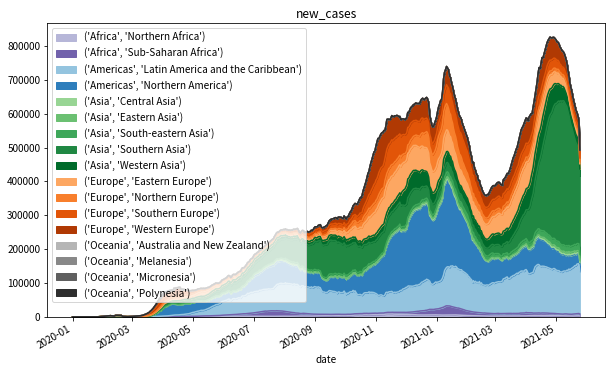

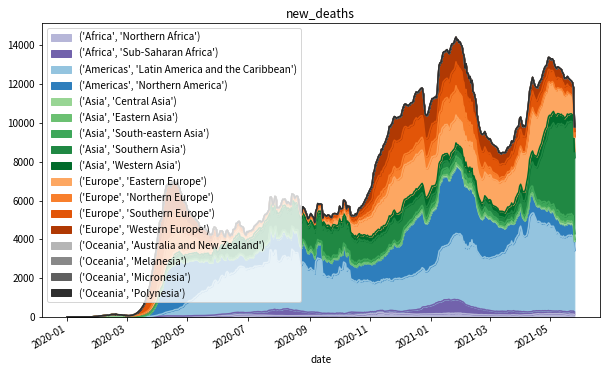

In [11]:
!mkdir -p world_trends/regions
regions = {k:[kk for kk, subdf in df.groupby("Sub-region Name")] for k, df in code_list.groupby("Region Name")}
color_names = ["Purples", "Blues", "Greens", "Oranges", "Greys"]
colors = []
for r, cn in zip(regions.keys(), color_names):
    cmap = plt.get_cmap(cn)
    sub_regions = regions[r]
    n_sr = len(sub_regions)
    mini_colors = [cmap((i / n_sr) * 0.6 + 0.4) for i in np.arange(0, n_sr)]
    colors += mini_colors
cmap = matplotlib.colors.ListedColormap(colors)

region_data = pd.merge(raw_data, code_list, left_on="iso_code", right_on="ISO-alpha3 Code", how="inner")
region_data.reset_index(inplace=True)
region_data["date"] = pd.to_datetime(region_data["date"])

def plot_regional(column, filename):
    def sum_region(df, cloumn):
        result= pd.DataFrame.from_dict([
            {str(k): v 
             for k,v in dict(df.groupby(["Region Name", "Sub-region Name"]).sum()[column]).items()
            }])
        return result

    region_sum = region_data.groupby("date").apply(sum_region, column)
    region_sum = region_sum.fillna(0).loc[region_sum.min(axis=1) >= 0].sort_index(axis=1)
    region_sum.reset_index(inplace=True)
    region_sum.drop("level_1", inplace=True, axis=1)
    region_sum.set_index("date", inplace=True)
    region_sum.rolling(7).mean().plot(kind="area", stacked="True", figsize=(10, 6), colormap=cmap, title=column)
    plt.savefig(filename, facecolor="white")
    plt.show()
    plt.close()

plot_regional("new_cases", "world_trends/regions/new_cases.png")
plot_regional("new_deaths", "world_trends/regions/new_deaths.png")

## 各国データの表示
各国のデータを7日間平均で表示する。

In [12]:
if False:
    !mkdir -p world_trends/country
    sorted_figs = []
    for country, df in data.items():
        continent = df["continent"][0]
#        fig, ax = plt.subplots()
        title = "%s-%s"%(continent, get_country(country))
        df2 = df[["new_cases","new_deaths"]].rolling(7).mean().fillna(0)
        ax = df2.plot(kind="area", stacked=False, alpha=0.2, title=title, ylim=(0,None), secondary_y=["new_deaths"])
        ax2 = ax.figure.get_axes()
        ax2[1].set_ylim(0,None)
        sorted_figs.append((title, ax.figure))
        ax.figure
        plt.savefig("world_trends/country/avg/%s-mean.png"%country)
        plt.close(ax.figure)
    sorted_figs = sorted(sorted_figs, key=lambda x: x[0])
    for title, fig in sorted_figs:
        display(fig)

## 統計処理
### 各国の陽性者数、死者数の集計

In [13]:
new_cases_label = "new_cases_per_million"
new_deaths_label = "new_deaths_per_million"
freq = 7

def calc_period(df):
    df2=df.reset_index()
#    result = df2.groupby([df2["date"].dt.year, df2["date"].dt.month]).mean()
    result = df2.groupby(pd.Grouper(key="date", freq="%dd"%freq, base=df2.shape[0] % freq )).mean()
    return result

trends = {}
for country, df in data.items():
    trends[country] = df[[new_cases_label, new_deaths_label, "continent"]]

def calc_trend_map(c, df):
    period = calc_period(df.drop("continent", axis=1))
    return (get_country(c), 
     df["continent"][0], 
     period[new_cases_label].values[-1], 
     period[new_deaths_label].values[-1])

trend_map = pd.DataFrame([calc_trend_map(country, df) for country, df in trends.items()],
                        columns=["country" , "continent", new_cases_label, new_deaths_label])

#display_full(trend_map.sort_values("new_cases", ascending=False).reset_index())

<ipython-input-13-9302de5effe9>:8: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  result = df2.groupby(pd.Grouper(key="date", freq="%dd"%freq, base=df2.shape[0] % freq )).mean()


### 陽性者の増減の傾向を計算
1. 各国の陽性者数の月別集計を実施
2. 前月との差分を計算

In [14]:
def calc_trends(df):
    period = calc_period(df)
    diff = period.diff()
    return (diff/period).fillna(0)

recents = pd.DataFrame([[c, get_country(c)] + list(calc_trends(df).iloc[-1]) for c, df in trends.items()], columns=["iso_code", "country", "trend_cases", "trend_deaths"])
status = pd.merge(trend_map, recents, on="country")

<ipython-input-13-9302de5effe9>:8: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  result = df2.groupby(pd.Grouper(key="date", freq="%dd"%freq, base=df2.shape[0] % freq )).mean()


## 可視化

In [15]:
ymin=10**-2
ymax=10**3
xmin=-2
xmax=2
cmap = plt.get_cmap('Set2')
colors = [cmap(c / 8) for c in np.arange(1, 8)]
countries = [get_country(c) for c in 
             ["JPN","KOR","CHN", "IND", "TWN", "THA",
              "FRA", "DEU", "GBR", "SWE",
              "USA", "BRA","CHL", "MYS", "ISR"]]

#全世界の状況をX-Yで散布図で可視化
def plot_scatter_worldwide(status, title='', x_column="trend_cases", y_column=new_cases_label, x_label='', y_label='', xlim=(xmin,xmax), ylim=(ymin, ymax), y_logscale=True, filename=''):
    fig,ax=plt.subplots(1,1, figsize=(8,8))
    xmin, xmax = xlim
    ymin, ymax = ylim
    i=0
    for continent, df in status.groupby("continent"):
        df.plot(ax=ax, kind="scatter", grid=True, 
                x=x_column, xlim=xlim, 
                y=y_column, logy=y_logscale, ylim=ylim, 
                color=colors[i], vmin=-1, vmax=1, 
                colorbar=False,
                title=title, label=continent, fontsize=13)
        i+=1
    for i,r in status.iterrows():
        x = r[x_column]
        y = r[y_column]
        country = r["country"]
        if country in countries:
            if xmin <= x and x < xmax and ymin <= y and y < ymax:
                if country == "Japan":
                    color = "red"
                    fontweight = "heavy"
                else:
                    color = "black"
                    fontweight = "normal"

                ax.annotate(country, xy=(x, y), color=color, fontweight=fontweight)

    ax.set_ylabel(y_label, fontsize=13)
    ax.set_xlabel(x_label, fontsize=13)
    ax.legend(loc='lower right')
    plt.vlines(0, ymin, ymax, linestyles="solid", color="darkred")

    !mkdir -p world_trends
    plt.savefig(filename)
    
#全世界の状況を大陸ごとにX-Yで散布図で可視化
def plot_scatter_per_continent(status, sub_continent = False, x_column="trend_cases", y_column=new_cases_label, x_label='', y_label='', xlim=(xmin,xmax), ylim=(ymin, ymax), y_logscale=True, filename=''):
    jp_x = None
    jp_y = None
    jp_index = None
    xmin, xmax = xlim
    ymin, ymax = ylim
    if sub_continent:
        status2 = pd.merge(status, code_list, left_on="iso_code", right_on="ISO-alpha3 Code", how="outer")
        grouper = ["Region Name", "Sub-region Name"]
        num_continents = 18
    else:
        status2 = status
        grouper = "continent"
        num_continents = 6
        
    fig,axs=plt.subplots(math.ceil(num_continents / 3), 3, figsize=(24, 8 * math.ceil(num_continents / 3)))
    index=0
    axs = axs.flatten().tolist() # m x n のグラフ表示では必要

    for continent, df in status2.groupby(grouper):
        ax = axs[index]
        df.plot(ax=ax, kind="scatter", grid=True, 
                x=x_column, xlim=xlim, 
                y=y_column, logy=y_logscale, ylim=ylim, 
                title=" - ".join(continent) if isinstance(continent, tuple) else continent, label=continent,
                fontsize=13,
                legend=False,
                colorbar=False,
                c=x_column, colormap="coolwarm", vmin=-1, vmax=1
                )
        ax.set_ylabel(y_label, fontsize=13)
        ax.set_xlabel(x_label, fontsize=13)
        ax.vlines(0, ymin, ymax, linestyles="solid", color="darkred")
        for i,r in df.iterrows():
            x = r[x_column]
            y = r[y_column]
            country = r["country"]
            if xmin <= x and x < xmax and ymin <= y and y < ymax:
                if country == "Japan":
                    jp_x = x
                    jp_y = y
                    jp_index = index
                    continue
                else:
                    color = "grey"
                    if country in countries:
                        fontweight = "bold"
                        color = "blue"
                    else:
                        fontweight = "normal"
                ax.annotate(country, xy=(x, y), color=color, fontweight = fontweight)
        index+=1
    axs[jp_index].annotate("Japan", xy=(jp_x, jp_y), color="red", fontweight = "bold")
    display(fig)
    #    plt.savefig("world_trends/trend-%s.png"%continent)
    plt.savefig(filename, facecolor="white")
    plt.close()

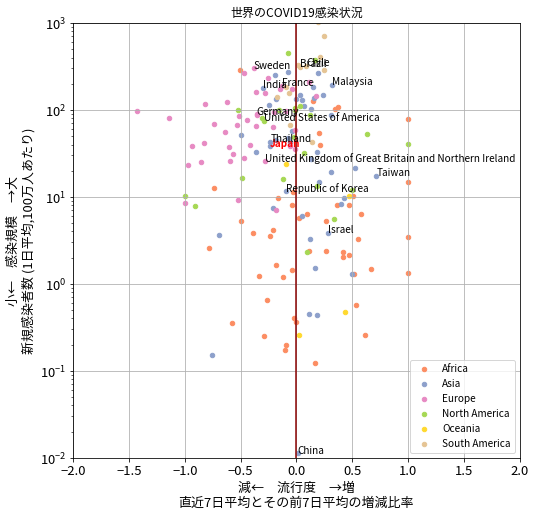

In [16]:

    
plot_scatter_worldwide(
    status, 
    title="世界のCOVID19感染状況",
    x_column="trend_cases", 
    y_column=new_cases_label,
    xlim = (xmin, xmax),
    ylim = (ymin, ymax),
    x_label="減←　流行度　→増\n直近{freq}日平均とその前{freq}日平均の増減比率".format(freq=freq), 
    y_label="小←　感染規模　→大\n新規感染者数 (1日平均,100万人あたり)", 
    filename="world_trends/trend.png")


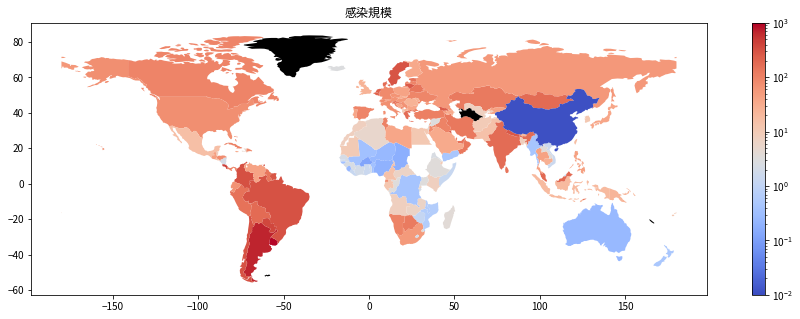

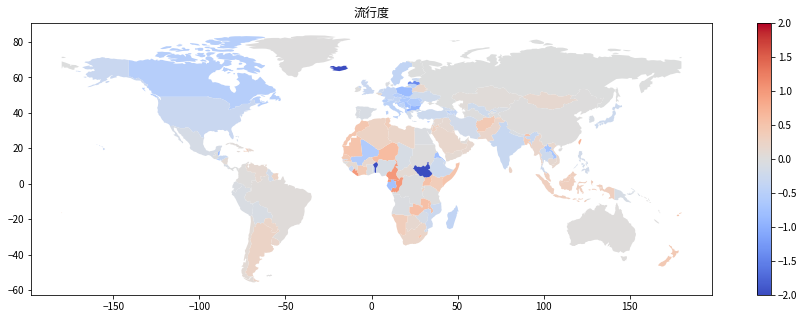

In [17]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world["country"] = [get_country(c) for c in world["iso_a3"]]
world = pd.merge(world, status, on="country", how="inner")
fig,ax=plt.subplots(figsize=(16,5))
world.plot(ax=ax, column=new_cases_label, legend=True, 
           cmap="coolwarm", norm=matplotlib.colors.LogNorm(vmin=ymin, vmax=ymax),
           missing_kwds={'color': 'black'})
ax.set_title("感染規模")
display(fig)
plt.savefig("world_trends/per_mill-ww-heatmap.png")
plt.close()

fig,ax=plt.subplots(figsize=(16,5))
world.plot(ax=ax, column="trend_cases", legend=True, 
           cmap="coolwarm", norm=matplotlib.colors.Normalize(vmin=xmin, vmax=xmax),
           missing_kwds={'color': 'black'})
ax.set_title("流行度")
display(fig)
plt.savefig("world_trends/trend-ww-heatmap.png")
plt.close()

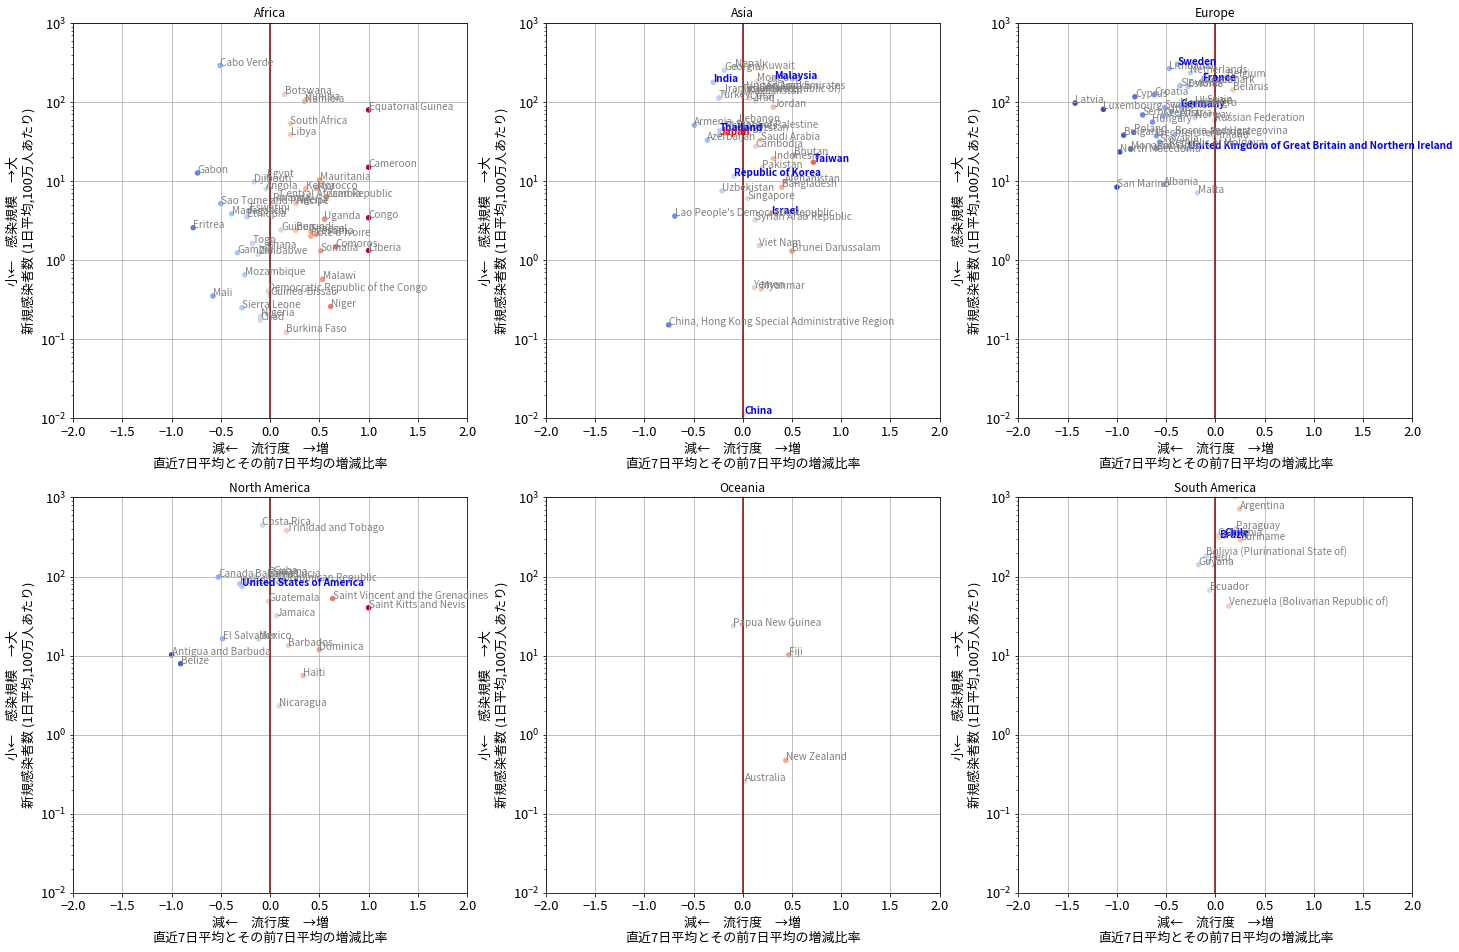

In [18]:
plot_scatter_per_continent(
    status, 
    sub_continent=False,
    x_column="trend_cases", 
    y_column=new_cases_label,
    xlim = (xmin, xmax),
    ylim = (ymin, ymax),
    x_label="減←　流行度　→増\n直近{freq}日平均とその前{freq}日平均の増減比率".format(freq=freq), 
    y_label="小←　感染規模　→大\n新規感染者数 (1日平均,100万人あたり)", 
    filename="world_trends/trend-continents.png")


## 第N波到来判定ロジック（その１）　→うまくいっていない
最大値の1/10以下の期間を挟んだら一回収束したと判定し、現在が第N波であると判定する。
- 現在の状況が上昇トレンドならN.0と表現
- 第N波中のピークを以前に迎えており、それよりも下降していたら、下記の計算式を用いてN.mと表現

   $m=\frac{ピークからの経過時間}{流行開始からの経過時間}$

In [19]:
def calc_waves(c, df):
    mean = df[["continent", "new_cases"]].rolling(7).mean()
    max_cases  = mean["new_cases"].max()
    threshold = max_cases / 10
    #lower = mean.loc[mean["new_cases"]<threshold]
    higher = mean.loc[mean["new_cases"]>=threshold]
    #timeline = higher.join(lower, how="outer", lsuffix="-higher", rsuffix="-lower")
    #if timeline.shape[0] > 0:
    #    timeline.plot(title=get_country(c))
    period = higher.reset_index()
    period["date_diff"] = (period["date"].diff() - timedelta(1)).fillna(timedelta(0)).cumsum()
    cont = []
    for k, pdf in period.groupby("date_diff"):
        dates = pdf["date"]
        start  = pdf.loc[dates == dates.min(), "date"].values
        end    = pdf.loc[dates == dates.max(), "date"].values
        days   = pdf["date_diff"].shape[0]
        g_mean = pdf["new_cases"].rolling(7).mean()
        peak   = pdf.loc[g_mean == g_mean.max(), "date"].values
        
        if days >= 21 and len(start) > 0 and len(end) > 0 and len(peak) > 0:
            cont.append( (pdf.iloc[0]["date"], days, peak[0], (end[0] - peak[0]) / (end[0] - start[0])) )
    
    return (c, df.iloc[0]["continent"], len(cont), 
            ([0]+[i[1] for i in cont])[-1], 
            ([0] + [i[2] for i in cont])[-1],
            ([0] + [i[3] for i in cont])[-1])

waves = pd.DataFrame([calc_waves(c, df) for c, df in data.items()], columns=["country", "continent", "waves", "continuous", "peak", "trend"])
waves["waves+"] = waves["waves"] + waves["trend"]
display(waves)

country      continent  waves  continuous                           peak  \
0       ABW  North America      0           0                              0   
1       AFG           Asia      3          42  2021-05-24T00:00:00.000000000   
2       AGO         Africa      2          90  2021-05-21T00:00:00.000000000   
3       AIA  North America      0           0                              0   
4       ALB         Europe      2         238  2021-02-15T00:00:00.000000000   
..      ...            ...    ...         ...                            ...   
210     WSM        Oceania      0           0                              0   
211     YEM           Asia      2          79  2021-04-07T00:00:00.000000000   
212     ZAF         Africa      2          96  2021-01-15T00:00:00.000000000   
213     ZMB         Africa      2         102  2021-01-22T00:00:00.000000000   
214     ZWE         Africa      2          59  2021-01-16T00:00:00.000000000   

        trend    waves+  
0    0.000000  0.000000  
1    0.000000  3.000000  
2    0.033708  2.033708  
3    0.000000  0.000000  
4    0.312236  2.312236  
..        ...       ...  
210  0.000000  0.000000  
211  0.474359  2.474359  
212  0.357895  2.357895  
213  0.722772  2.722772  
214  0.465517  2.465517  

[215 rows x 7 columns]

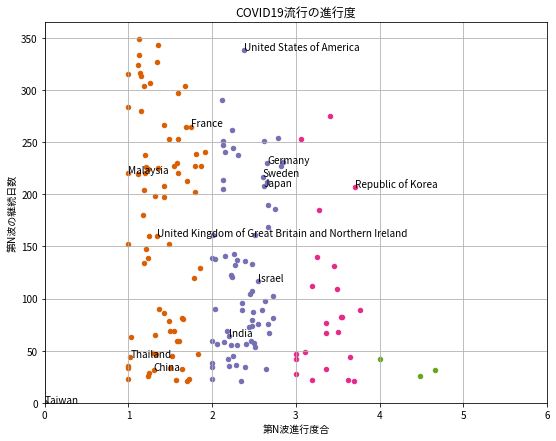

In [20]:
cmap = plt.get_cmap('Dark2')
colors = [cmap(c / 8) for c in np.arange(1, 8)]

fig,ax=plt.subplots(1,1, figsize=(9,7))
for i, wv in waves.groupby("waves"):
    wv.plot(ax=ax, kind="scatter", grid=True, 
            x="waves+", xlim=(0,6), 
            y="continuous", ylim=(0, 365),
            title="COVID19流行の進行度",
            legend=False, color=colors[i-1])
    ax.set_ylabel("第N波の継続日数")
    ax.set_xlabel("第N波進行度合")
for i,r in waves.iterrows():
    x = r["waves+"]
    y = r["continuous"]
    country = get_country(r["country"])
    if (country in countries) and 0 <= x and x < 6 and 0 <= y and y < 365:
        ax.annotate(country, xy=(x, y))
display(fig)
plt.savefig("world_trends/waves.png")
plt.close(fig)

## 第N波判定ロジック（その２）
前後20日の移動平均の前日との差分から現在が上昇/下降のいずれかであるかを判定し、上昇→下降で第N派が終わったとみなして判定。
長期的なトレンドを見るために以下の処理を追加。
- 微細な変化（７日以内）の変化は無視して「変化なし」扱いとする
- 最大の上昇/下降変化に対して2.5%以内の微細な変化は「変化なし」扱いとする

In [21]:
def calc_waves2(c, df):
    # 前後20日間の移動平均を取る
    trend = df[["continent", "new_cases"]].rolling(20,center=True, min_periods=1).mean()
    # 移動平均の差分を計算し、さらに20日間の移動平均で丸める
    trend["sign"] = trend["new_cases"].diff().fillna(0).rolling(20,center=True, min_periods=1).mean()
    # 差分の絶対値が最大値の1/40未満の要素を0に切り下げ
    trend_max     = trend["sign"].max()
    trend.loc[trend["sign"].abs() < trend_max / 40, "sign"] = 0
    # 符号を計算
    trend["sign"] = np.sign(trend["sign"])
    # 符号が連続する期間を計算し、グループ番号(step)を振る
    trend["step"] = trend["sign"].diff().fillna(0).abs().cumsum()

    # 符号が連続する期間をまとめ、期間を行に持つDataFrameを作成する
    def extract_region(step, rdf):
        start = rdf.loc[rdf["date"] == rdf["date"].min(), "date"].values[0]
        end   = rdf.loc[rdf["date"] == rdf["date"].max(), "date"].values[0]
        return [(end - start) / np.timedelta64(1, 'D') + 1, rdf["sign"].values[0], rdf["new_cases"].sum()]    
    result = pd.DataFrame([extract_region(step, rdf) for step, rdf in trend.reset_index().groupby("step")], columns=["days", "sign", "new_cases"])
    
    # 連続が7日以内の短期変化は符号を0にして均す
    result.loc[result["days"] < 7, "sign"] = 0
    result["step"] = result["sign"].diff().fillna(0).abs().cumsum()

    # 符号が0で連続する期間をまとめる
    def sum_zeros(rdf):
        return rdf.sum()
    result = result.groupby("step").apply(sum_zeros).drop("step", axis=1)
    return result

waves2 = dict([(c, calc_waves2(c, ddf)) for c, ddf in data.items()])

### 可視化

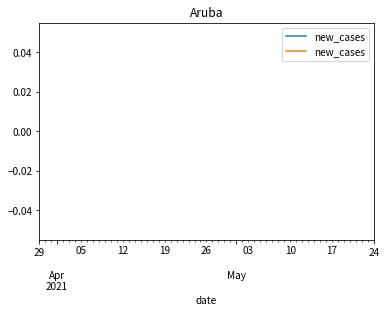

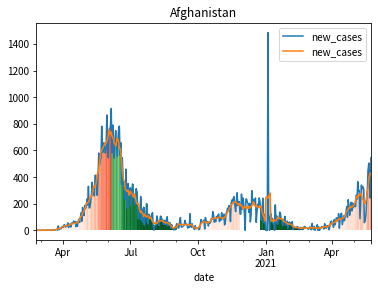

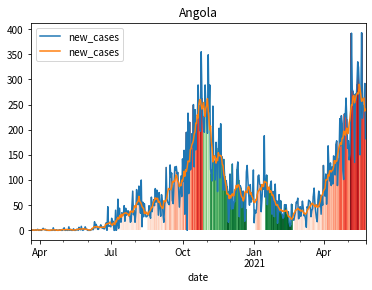

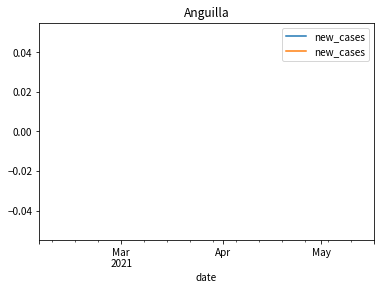

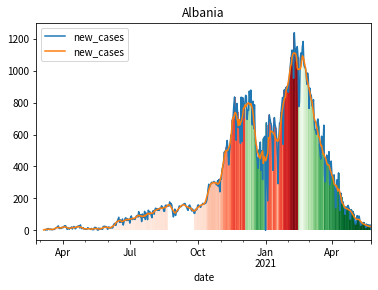

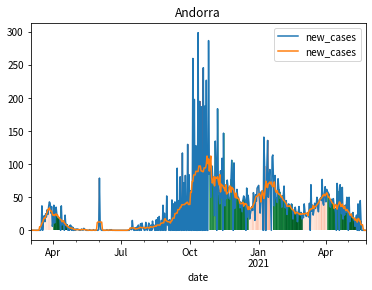

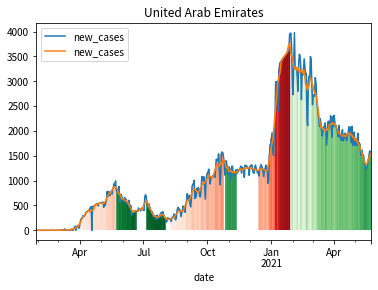

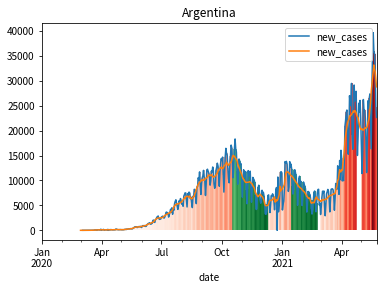

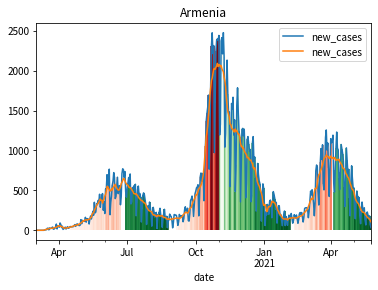

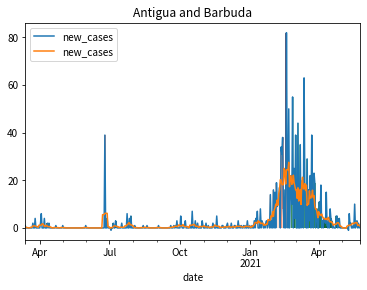

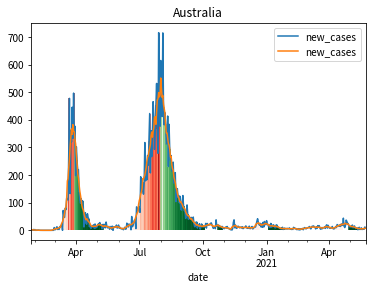

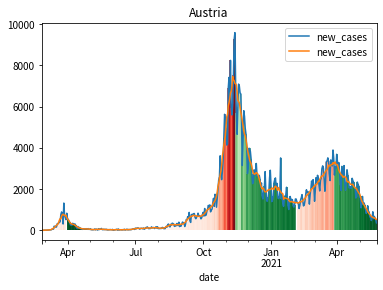

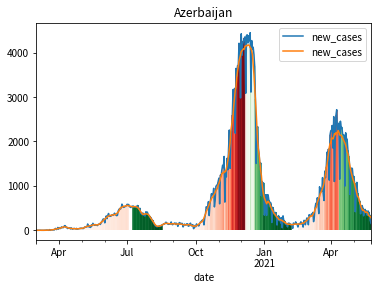

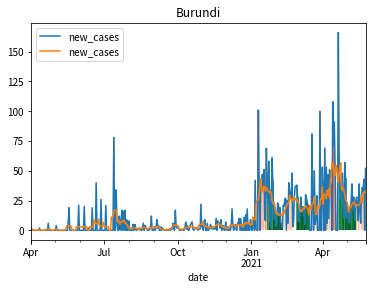

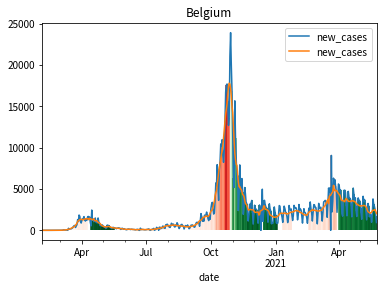

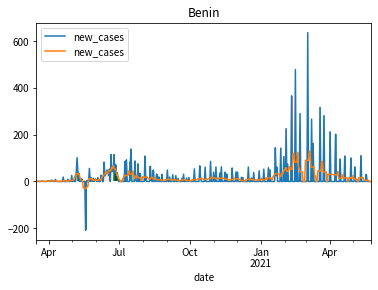

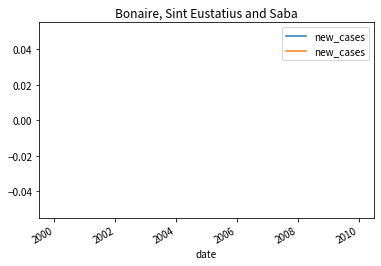

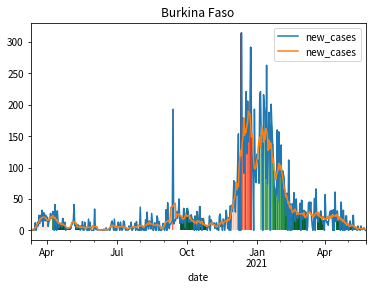

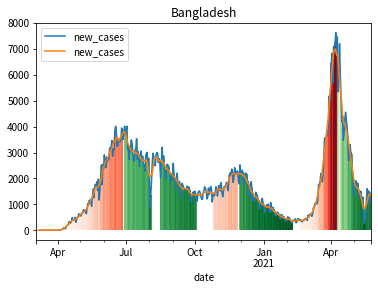

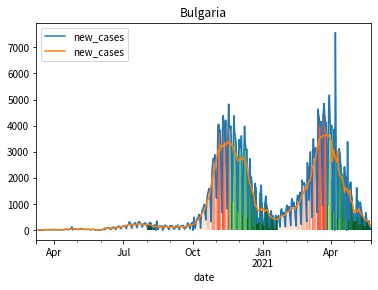

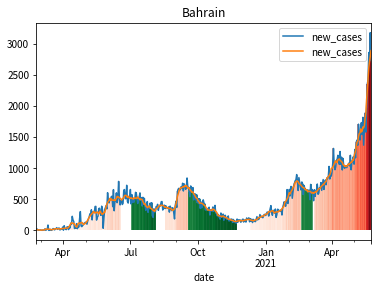

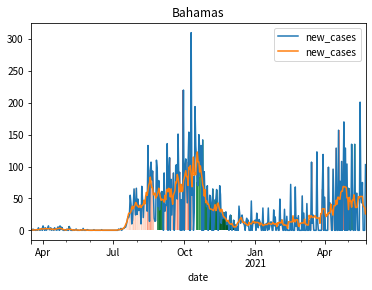

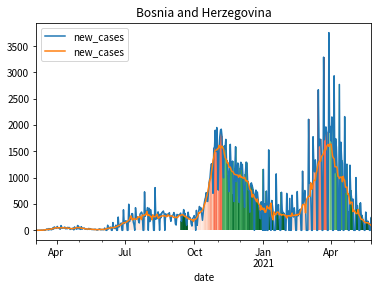

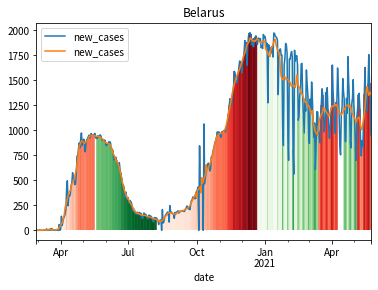

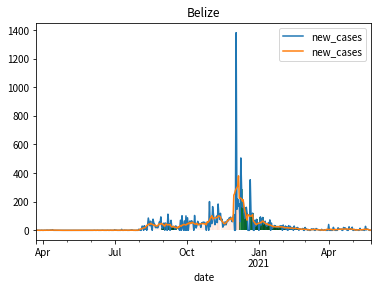

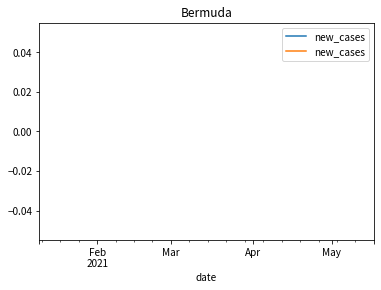

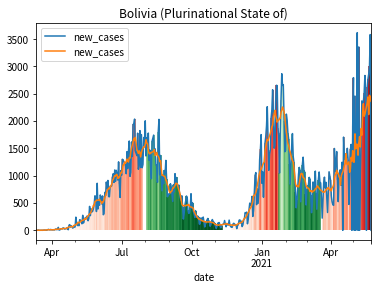

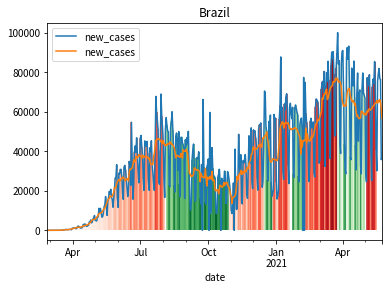

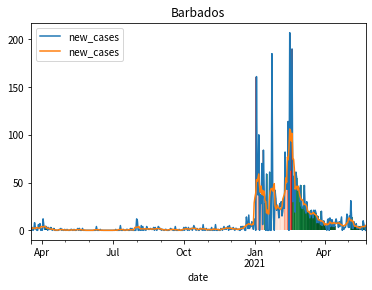

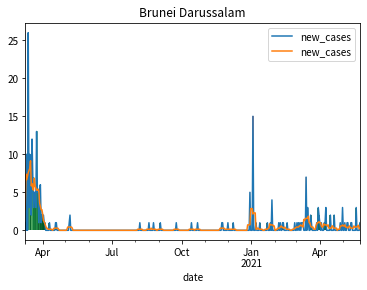

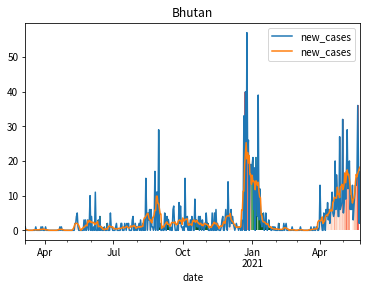

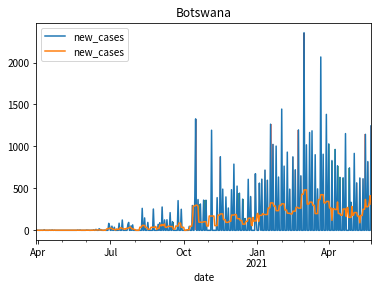

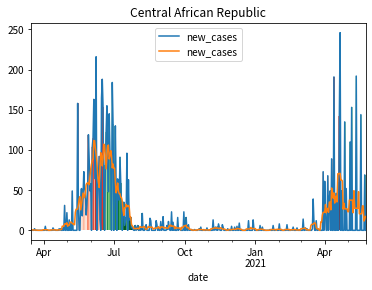

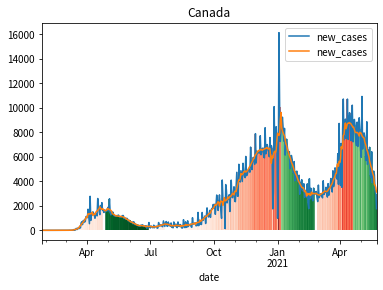

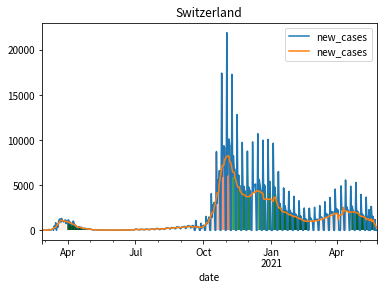

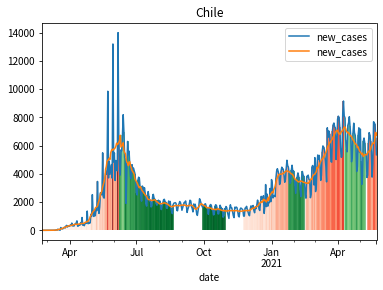

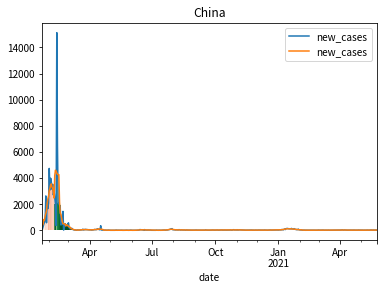

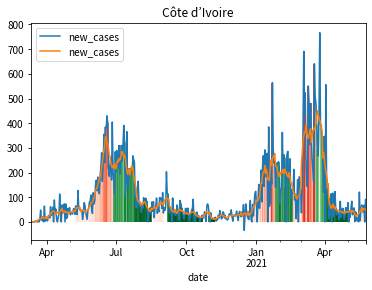

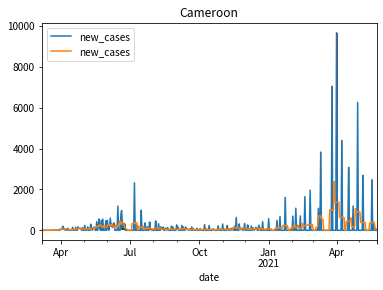

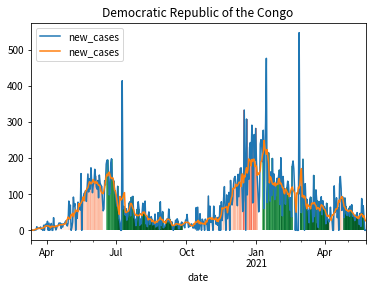

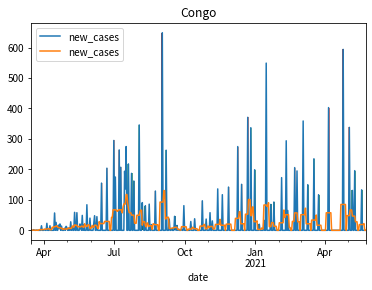

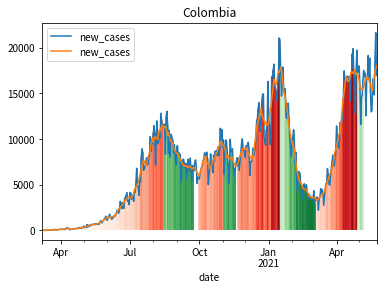

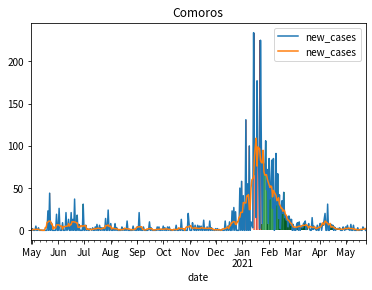

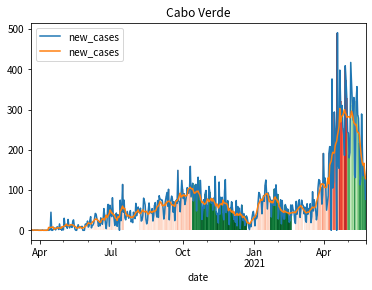

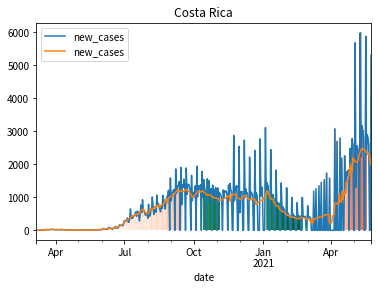

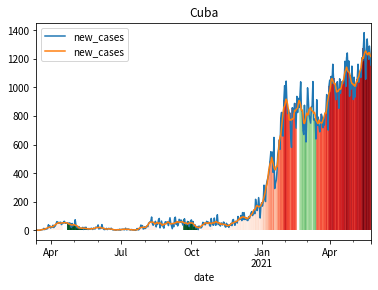

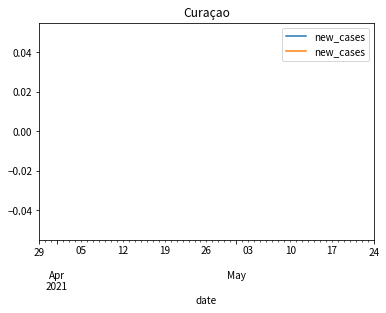

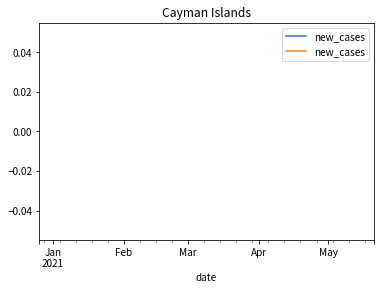

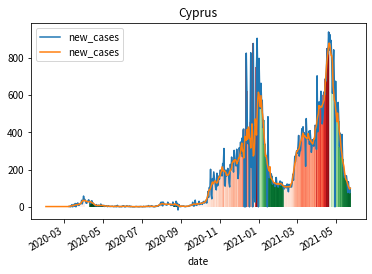

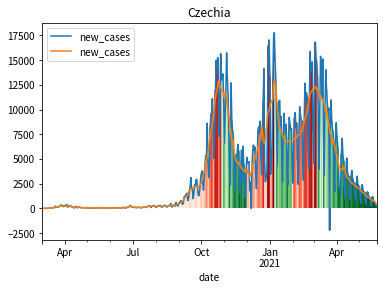

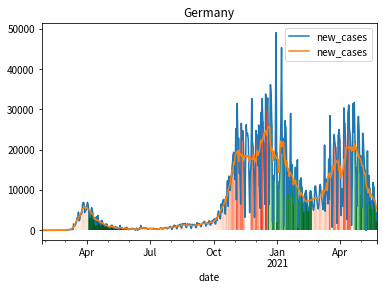

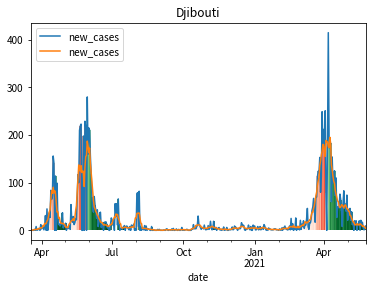

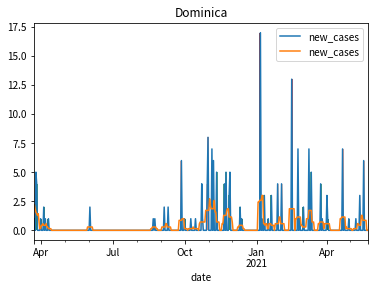

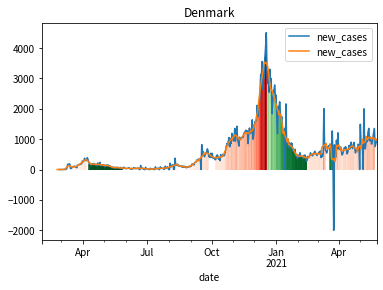

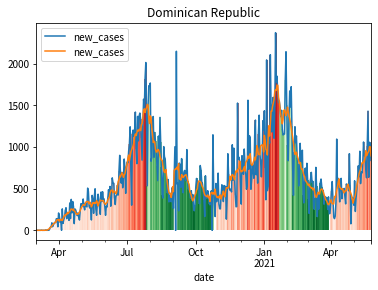

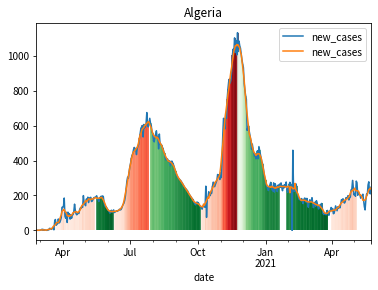

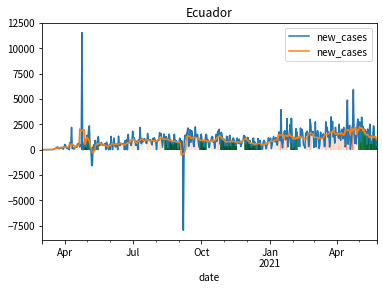

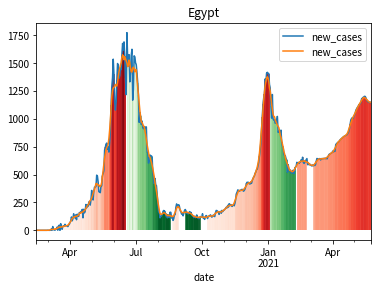

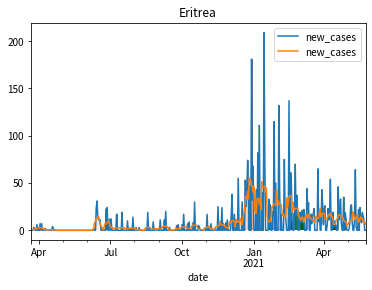

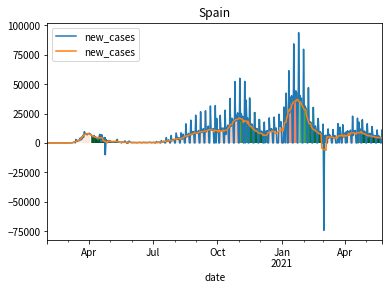

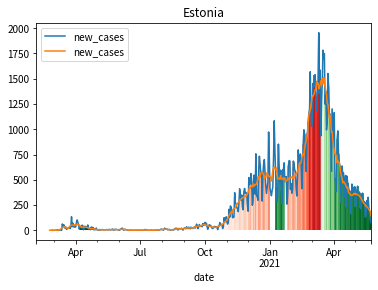

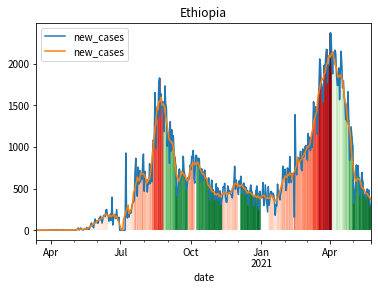

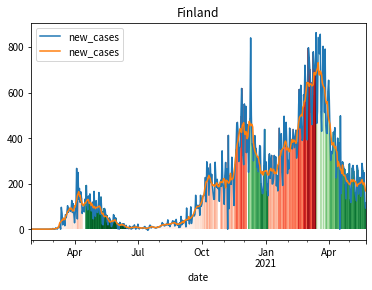

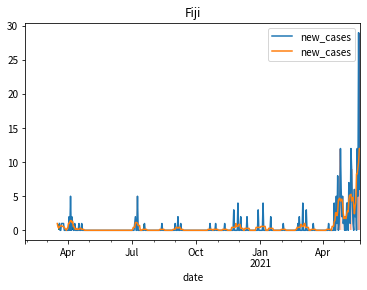

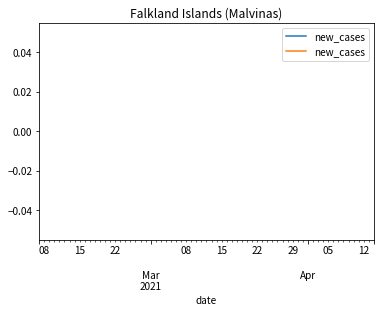

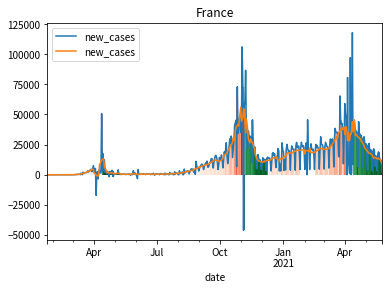

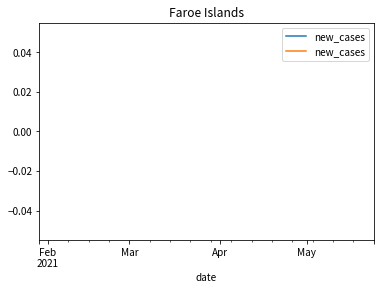

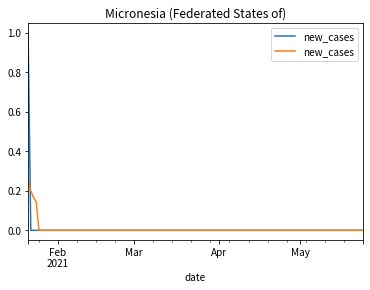

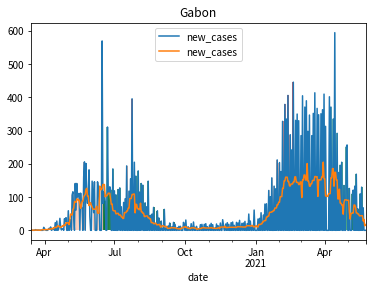

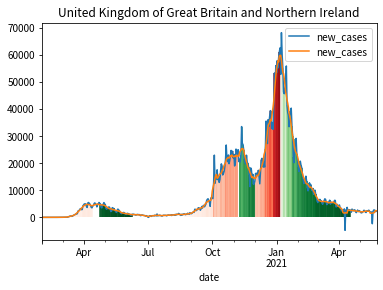

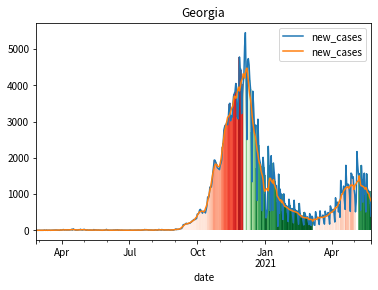

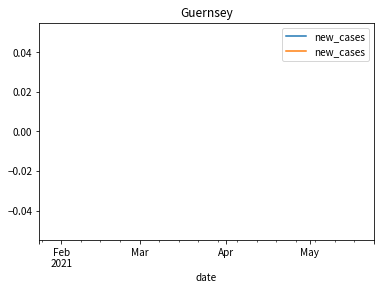

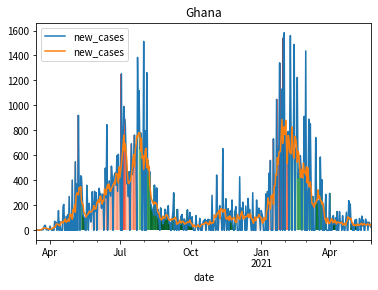

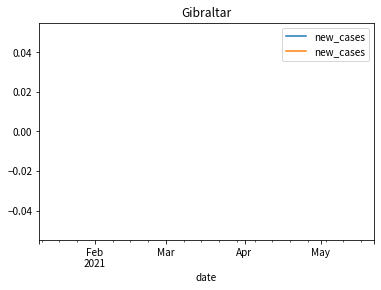

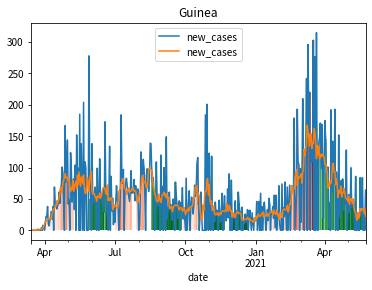

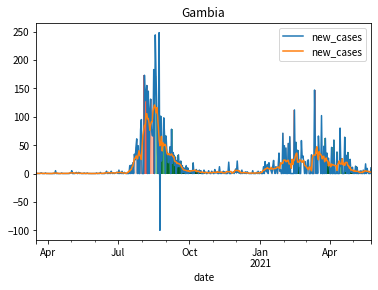

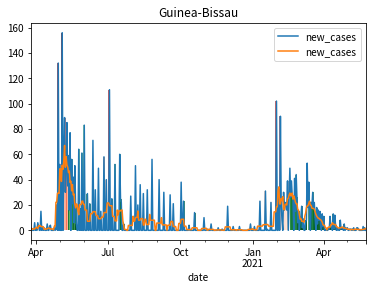

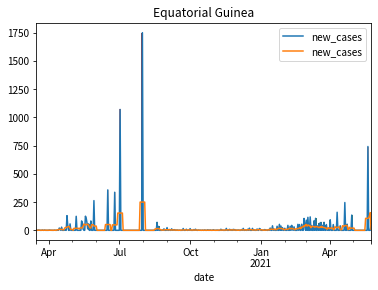

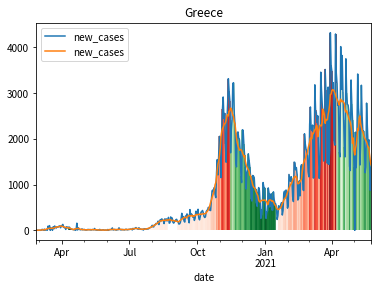

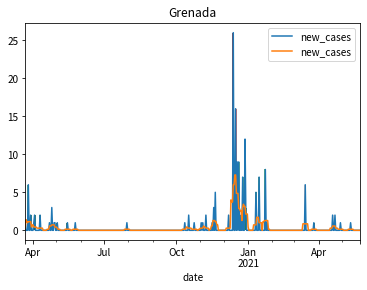

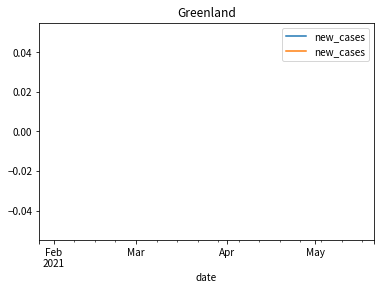

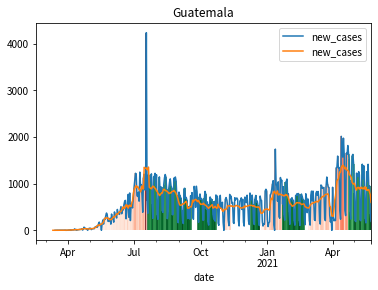

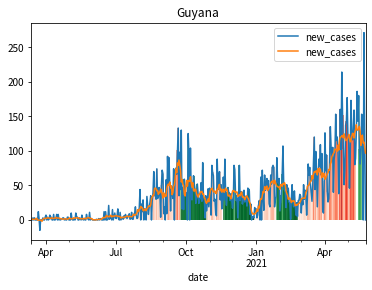

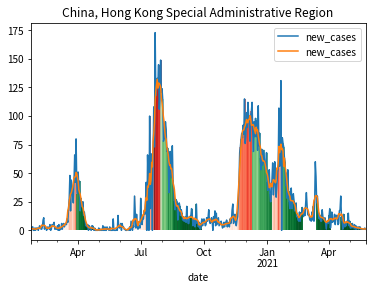

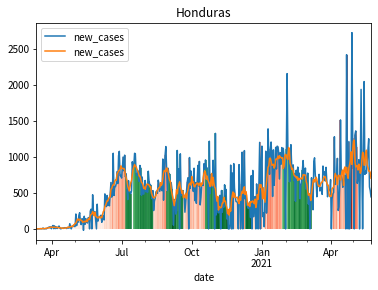

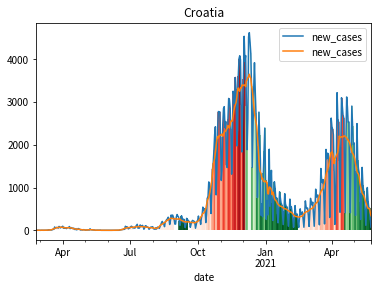

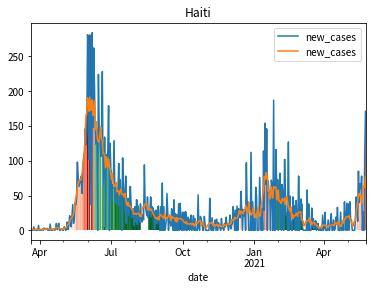

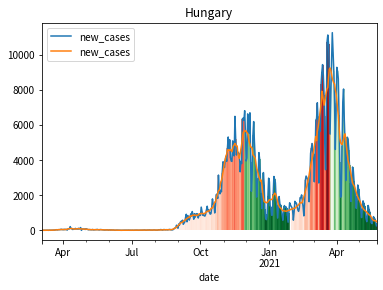

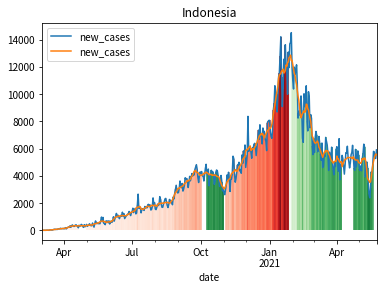

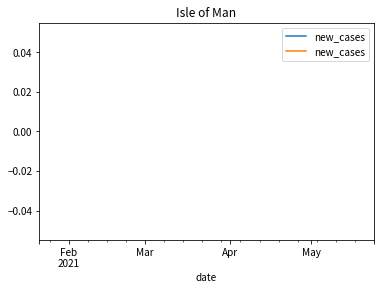

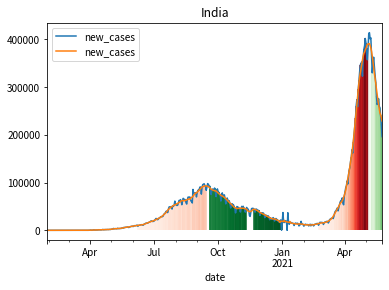

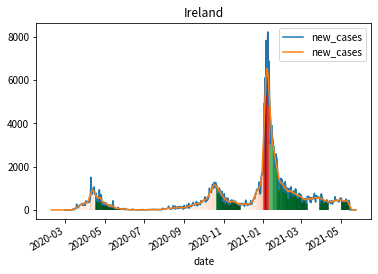

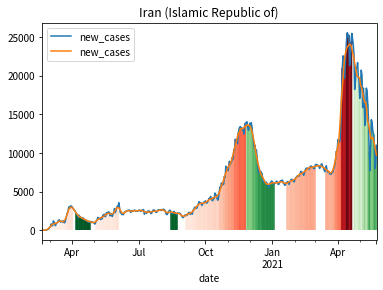

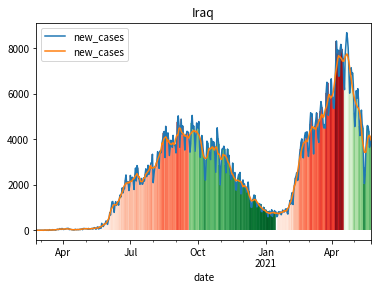

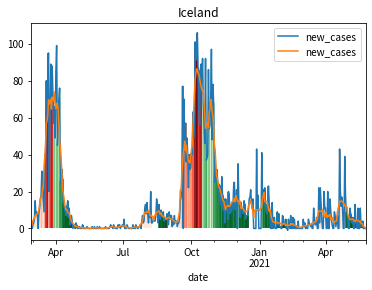

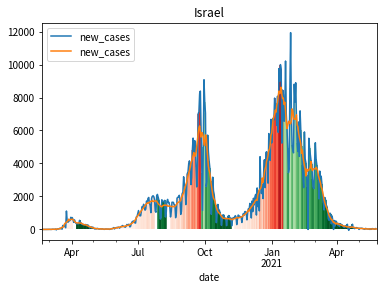

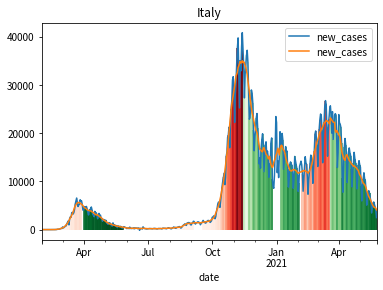

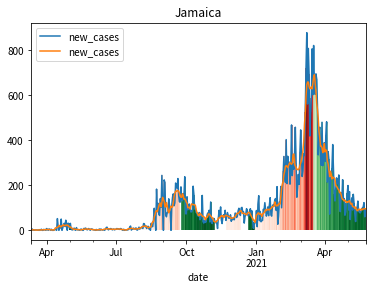

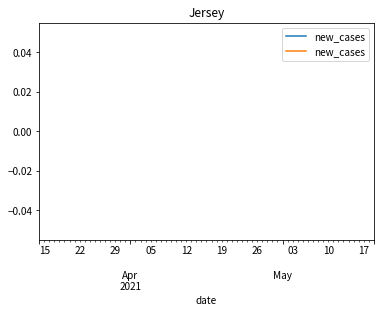

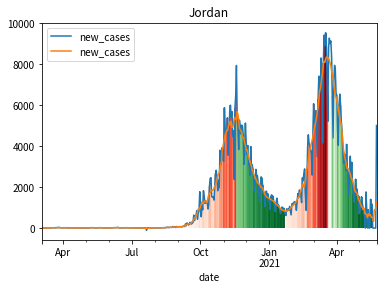

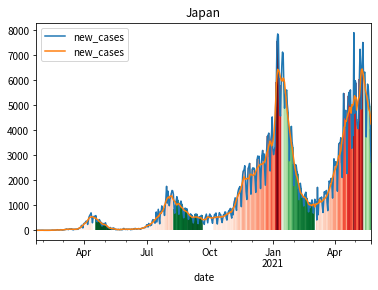

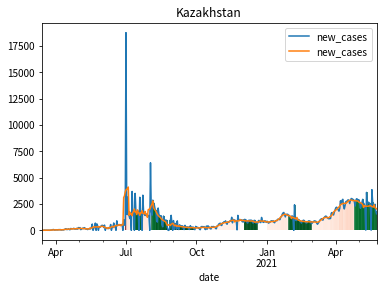

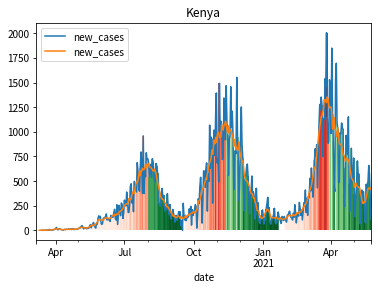

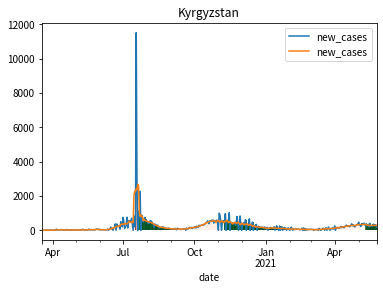

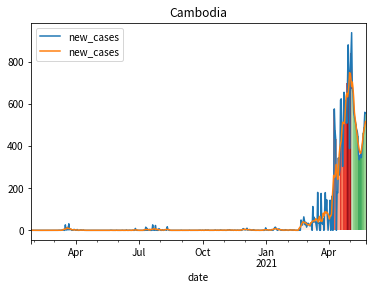

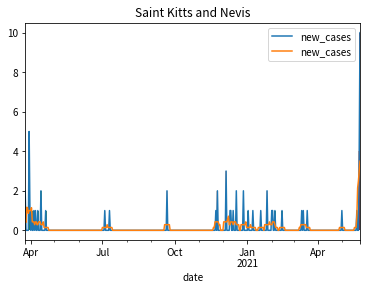

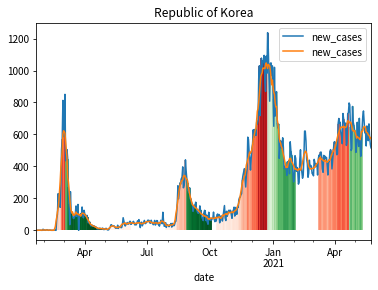

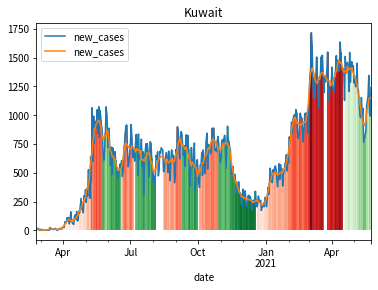

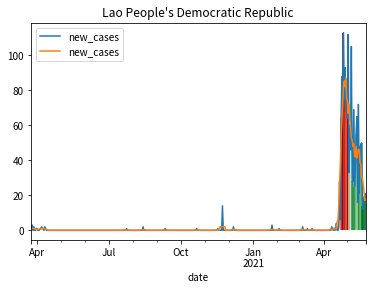

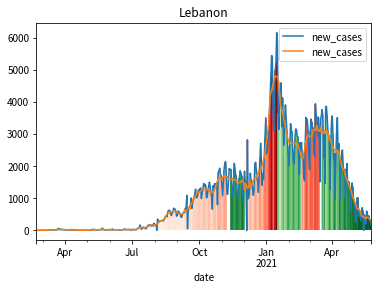

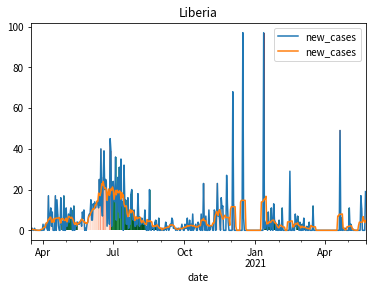

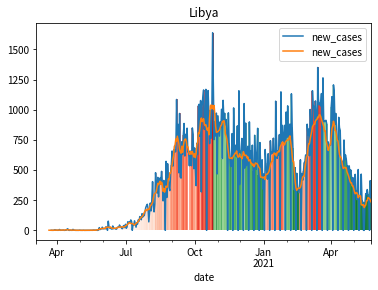

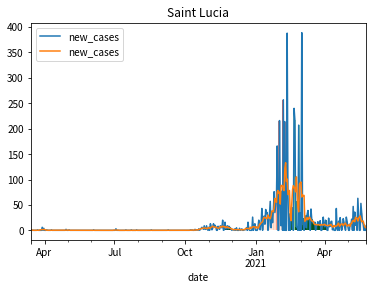

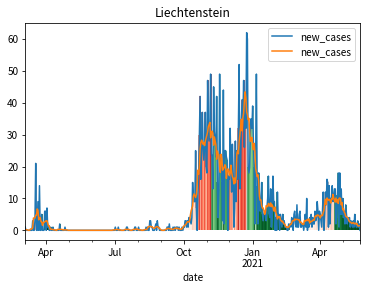

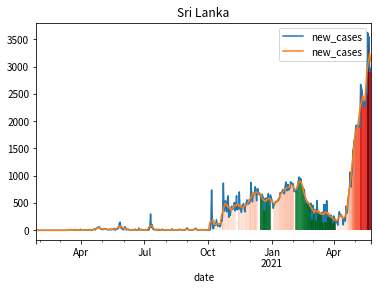

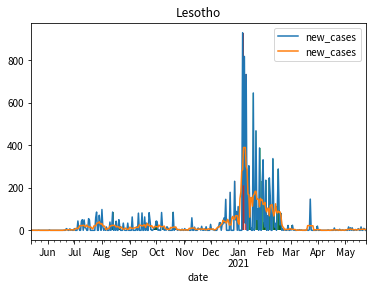

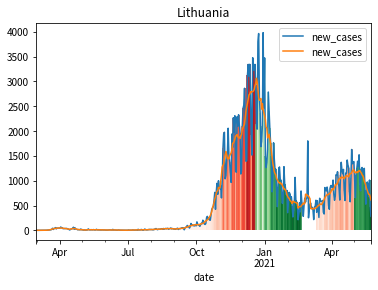

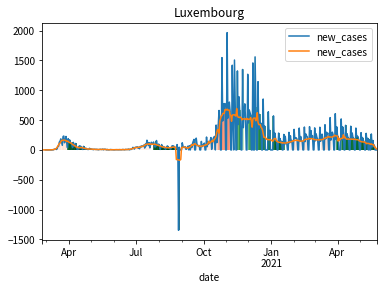

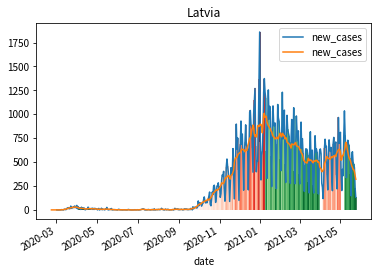

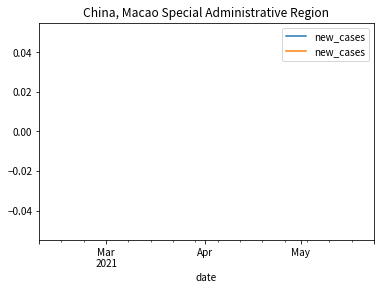

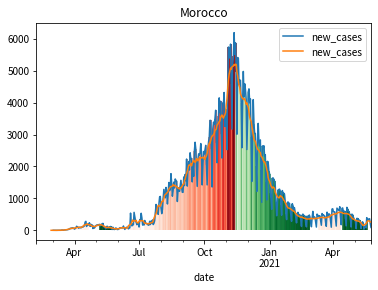

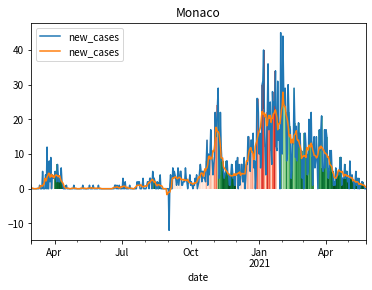

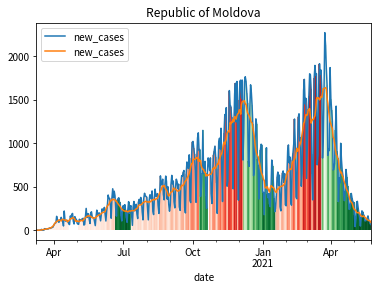

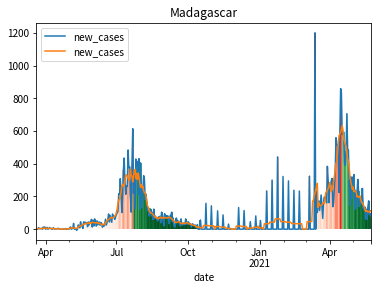

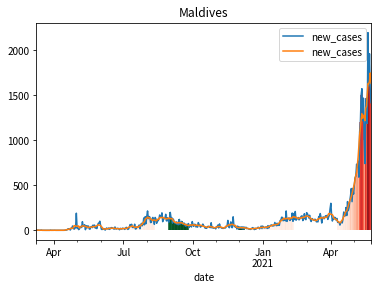

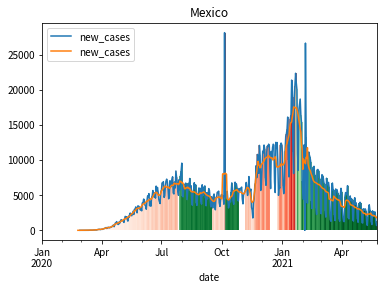

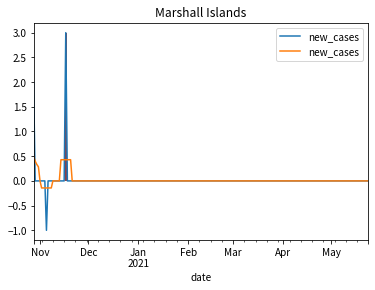

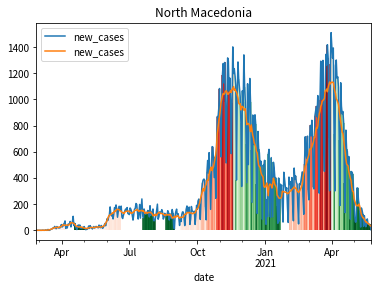

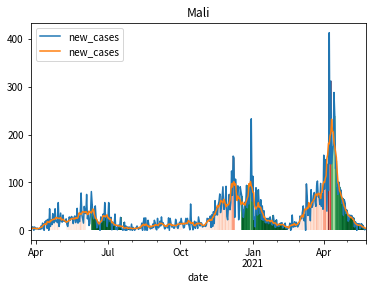

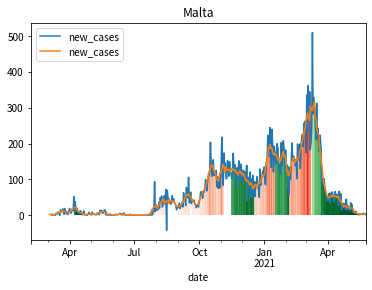

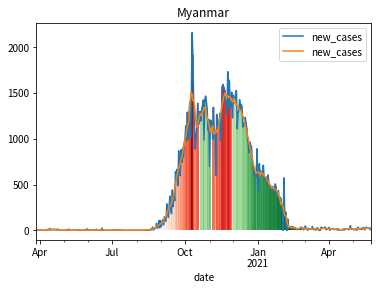

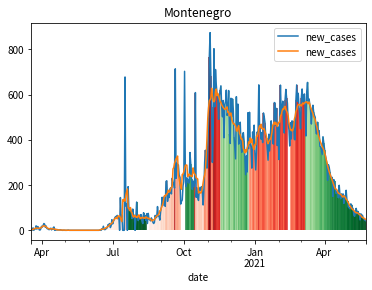

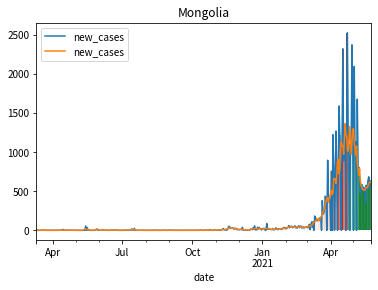

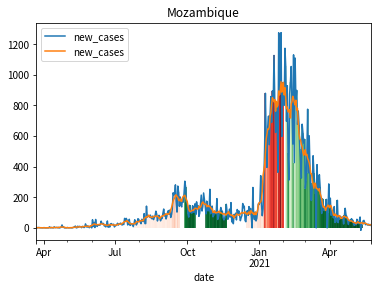

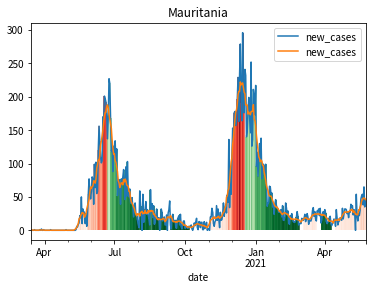

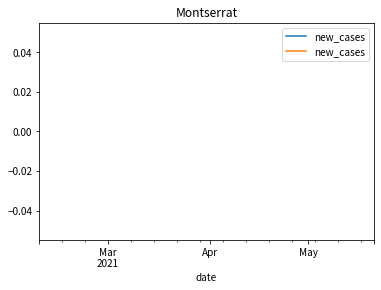

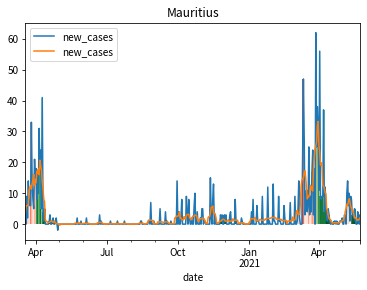

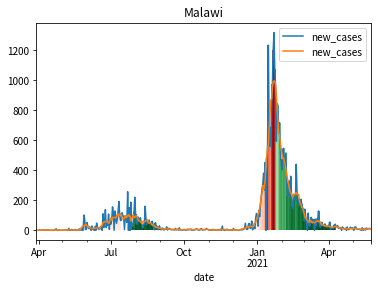

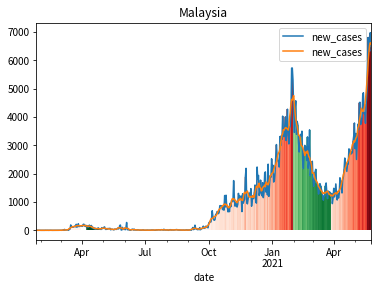

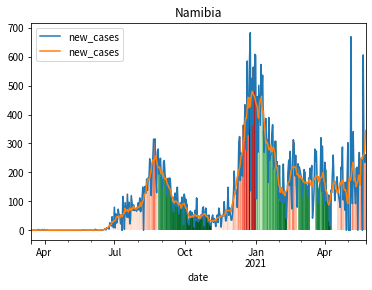

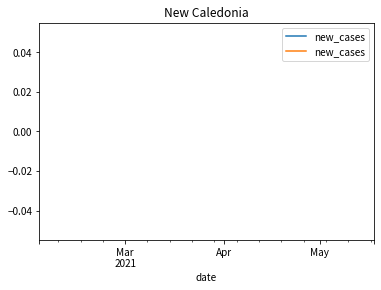

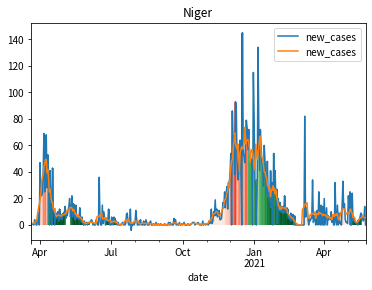

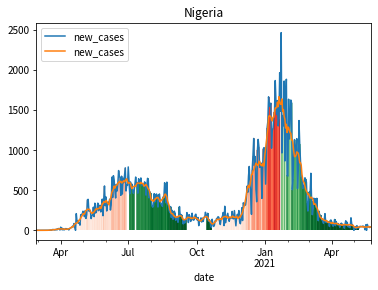

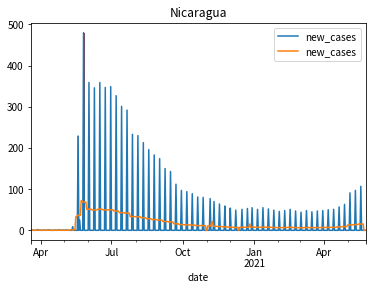

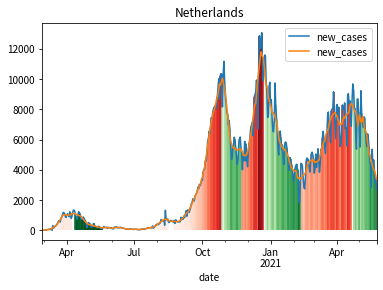

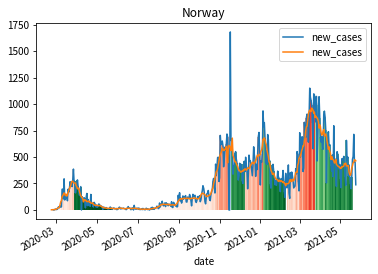

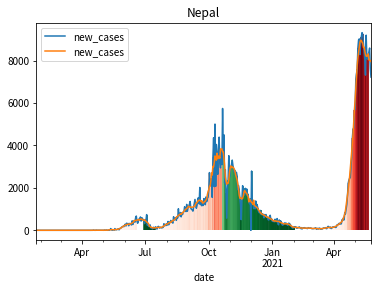

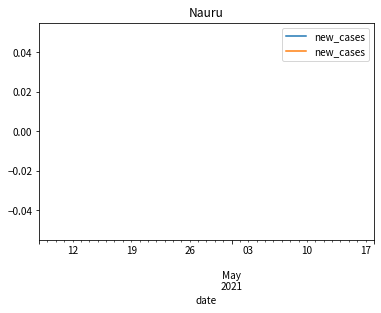

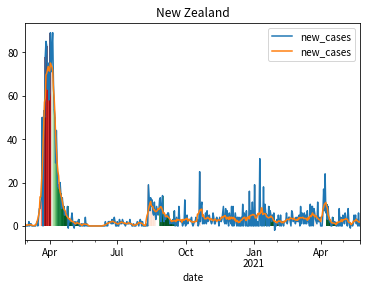

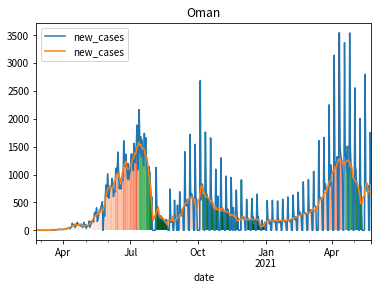

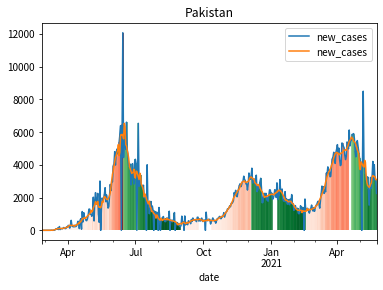

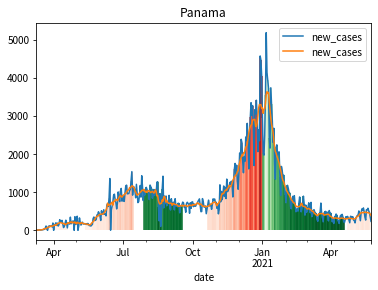

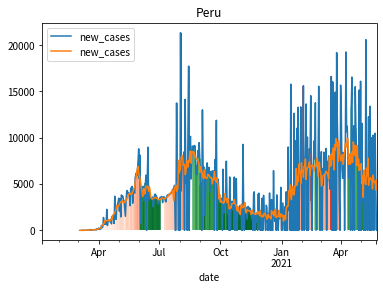

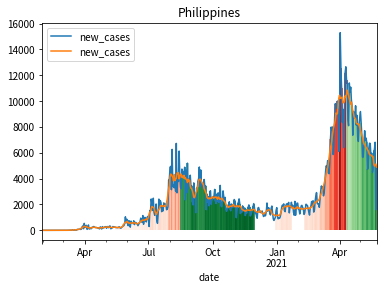

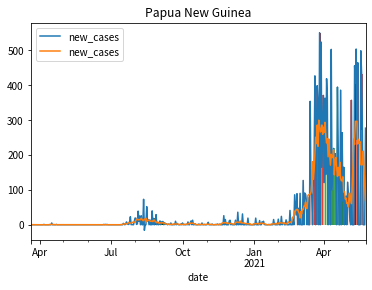

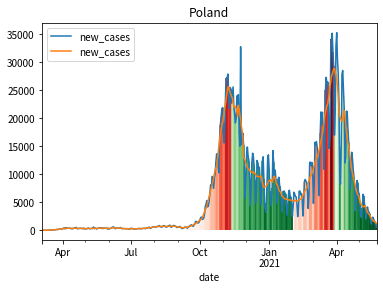

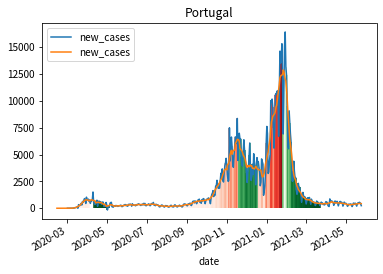

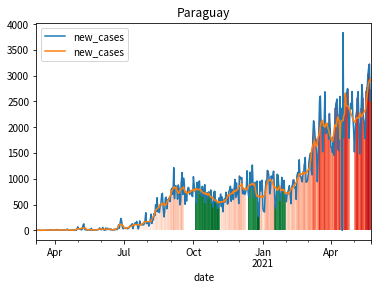

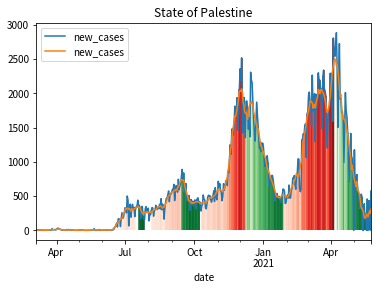

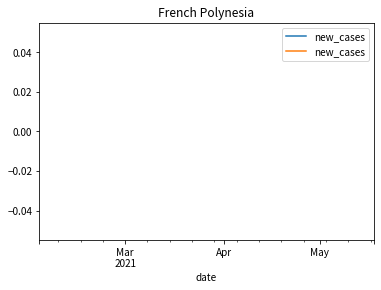

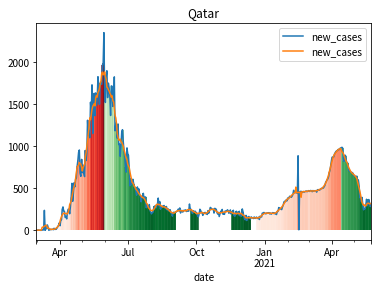

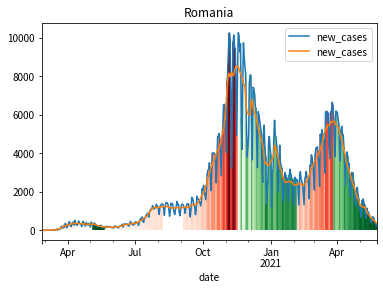

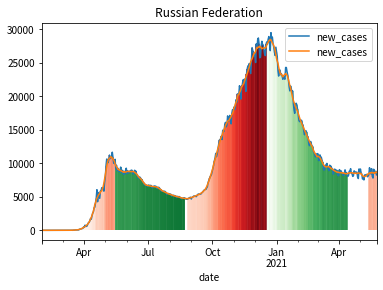

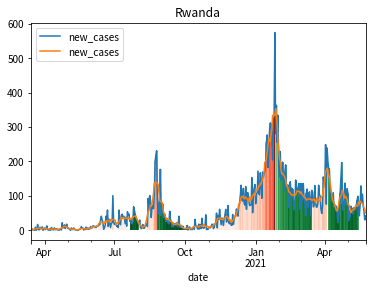

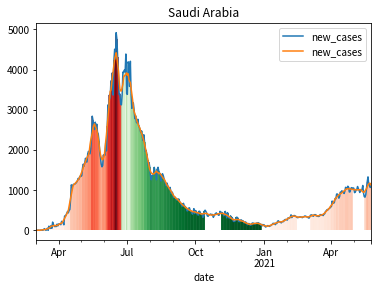

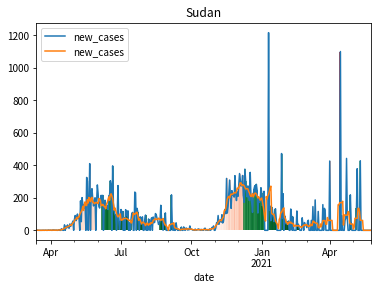

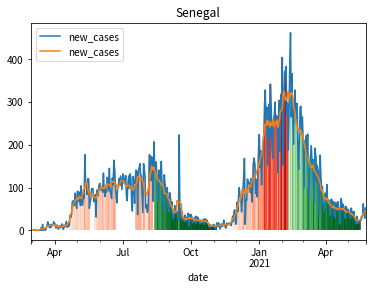

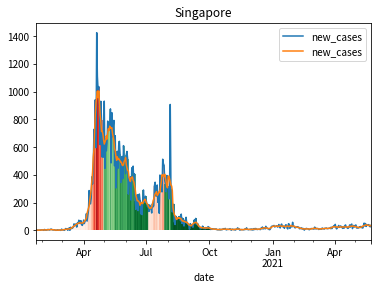

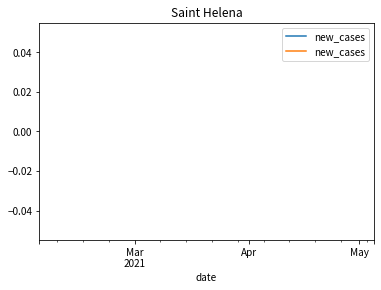

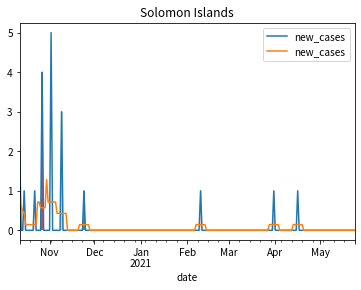

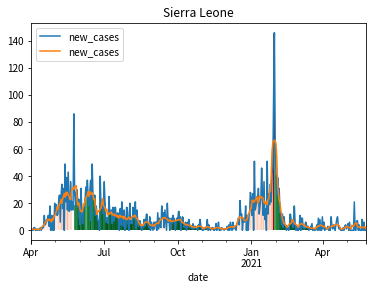

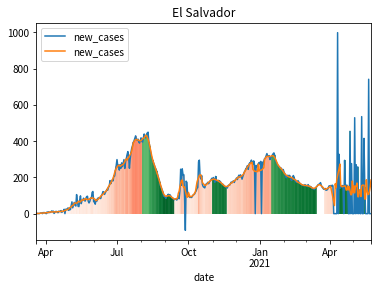

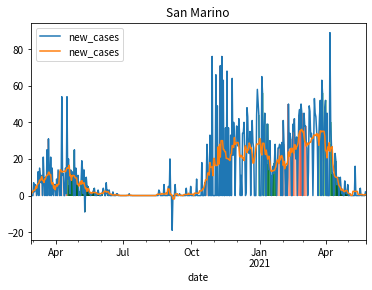

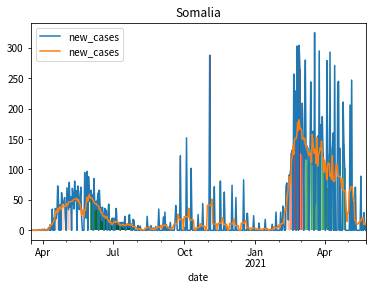

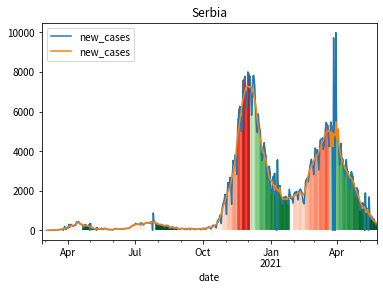

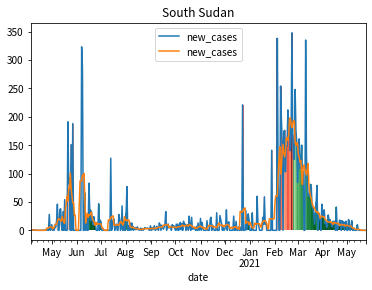

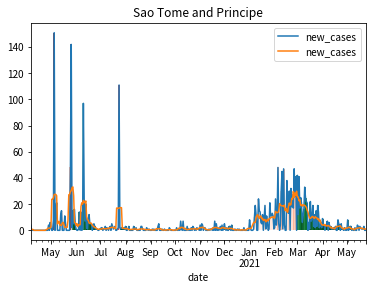

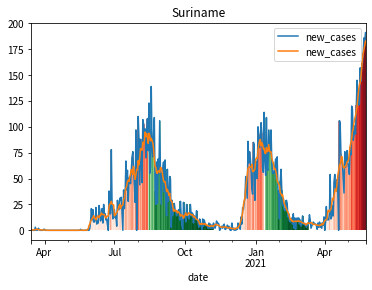

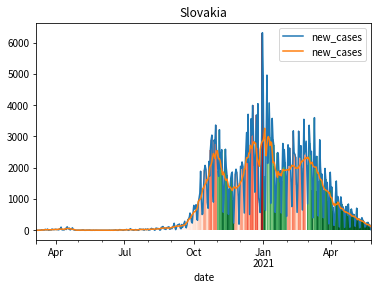

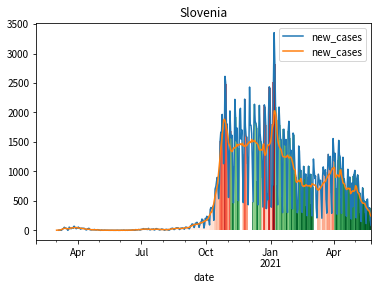

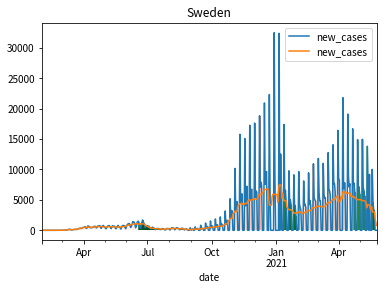

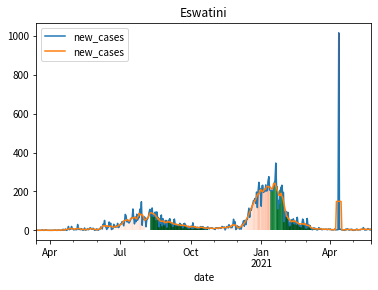

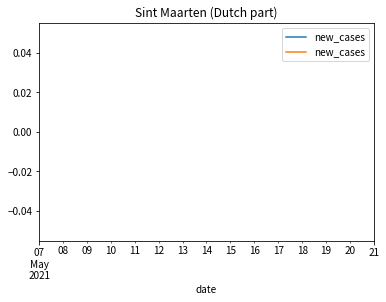

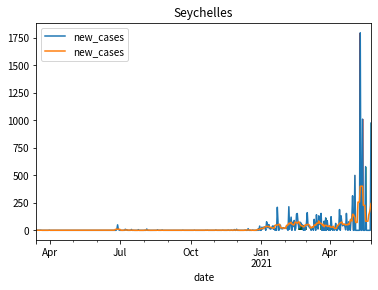

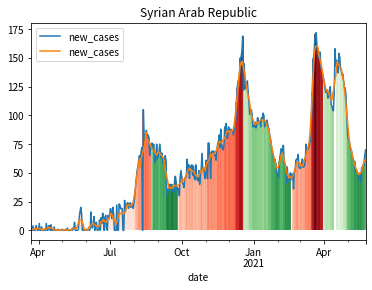

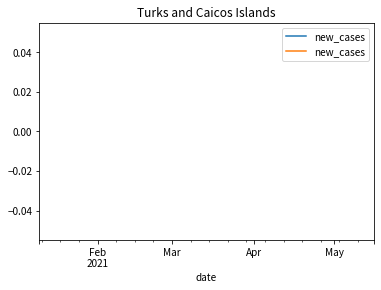

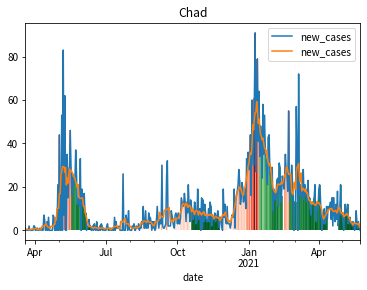

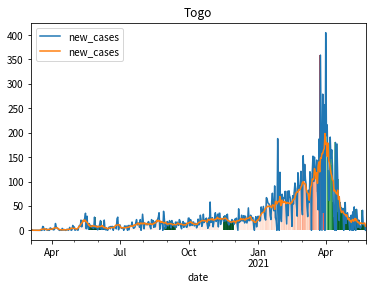

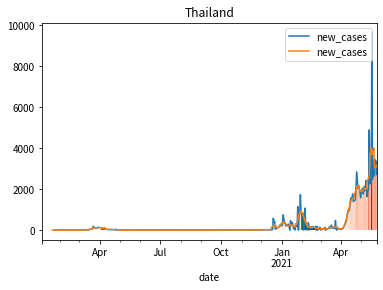

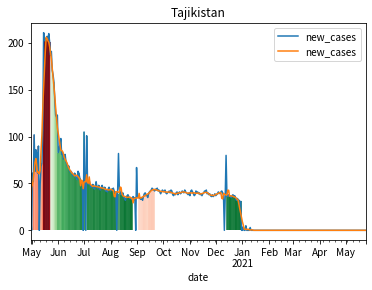

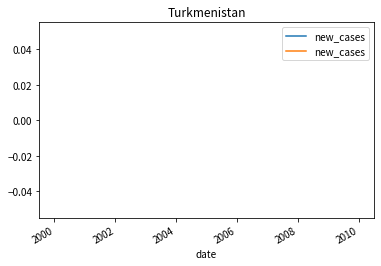

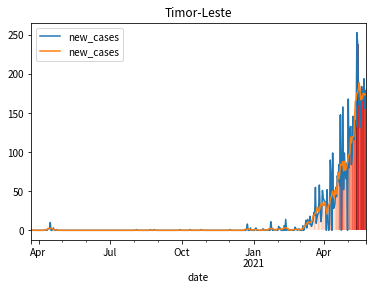

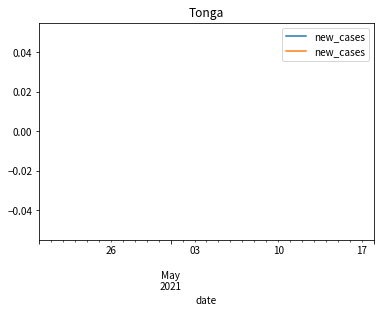

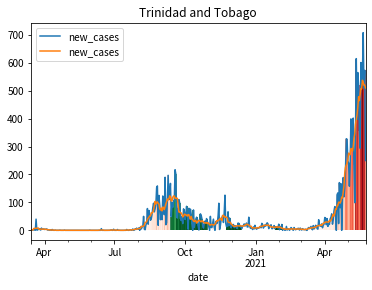

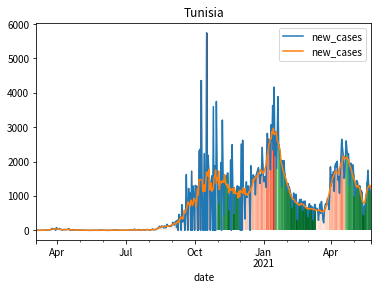

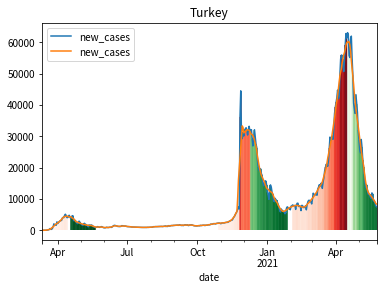

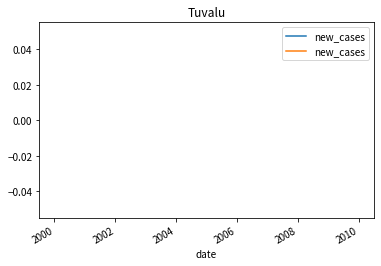

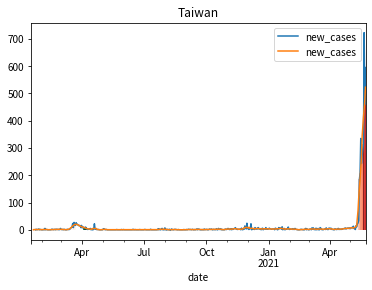

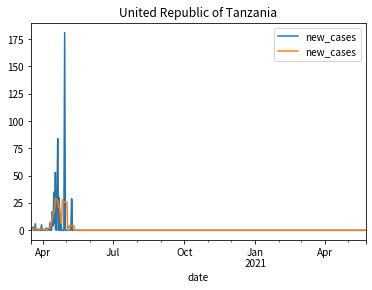

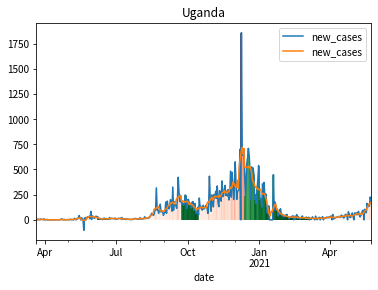

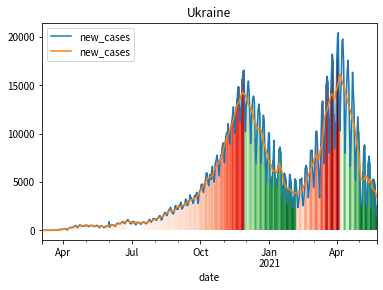

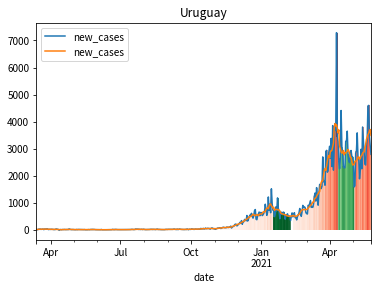

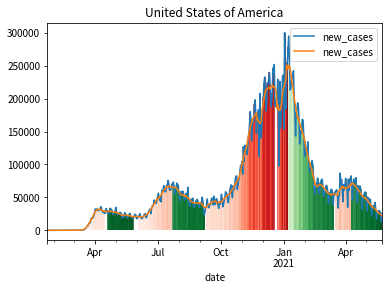

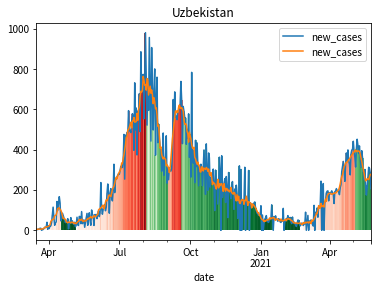

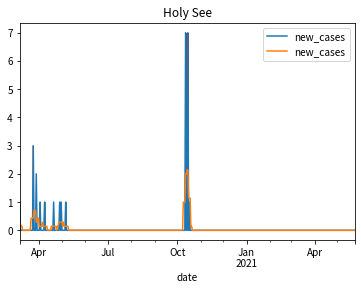

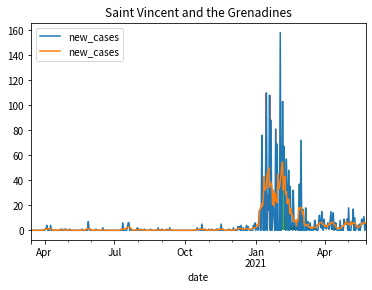

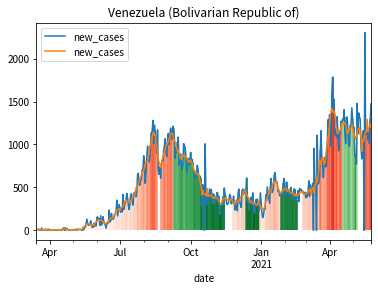

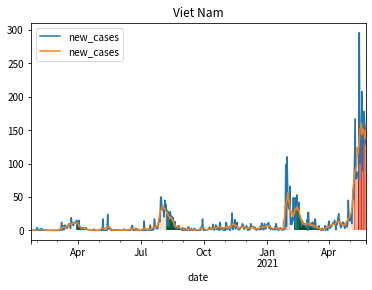

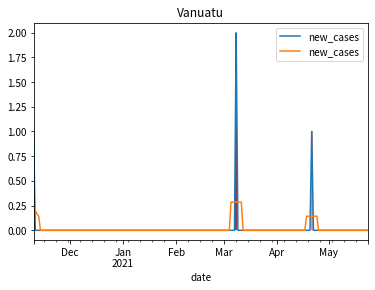

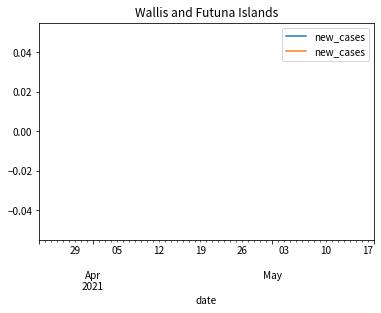

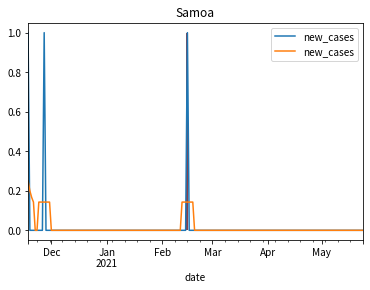

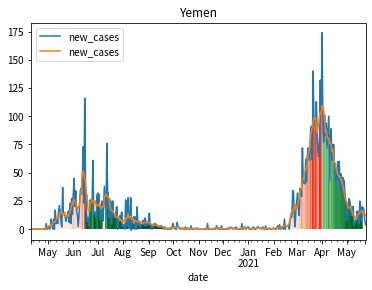

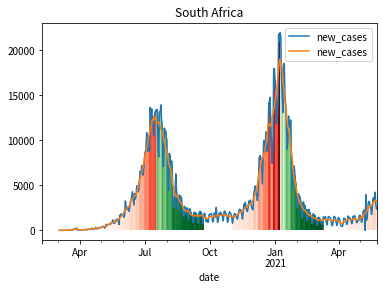

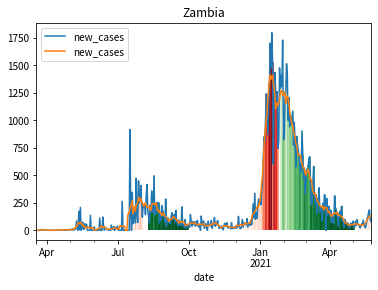

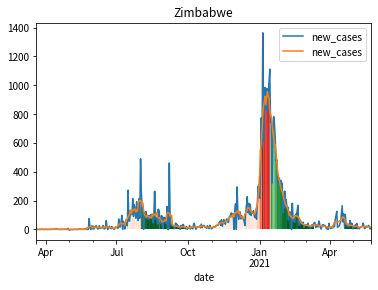

In [22]:
reds   = plt.get_cmap('Reds')
greens = plt.get_cmap('Greens')
for wvs, dfs in zip(waves2.items(), data.items()):
    c,wv = wvs
    cc,df = dfs
    
    # 新規感染者数をプロット
    ax  = df.plot(y="new_cases", title=get_country(c))
    df.rolling(7,center=True, min_periods=1).mean().plot(ax=ax, y="new_cases", title=get_country(c))

    # 上昇/下降の期間を色で表現。最大値に対する振れ幅で色の濃淡を変えて表示する
    day = df.reset_index()["date"].dt.to_pydatetime()[0]
    target = data[c].reset_index()
    y_max  = target["new_cases"].max()

    def to_reds(x):
        return reds(x / y_max)
    def to_greens(x):
        return greens(1 - x / y_max)
    
    # xsに含まれる期間のy1s - y2sの間を塗りつぶす。その際、y2s-y1sの値で色の濃淡を決定する
    def fill_between(xs, y1s, y2s, colors):
        for i in range(0, len(xs)):
            x1  = xs[i]
            y11 = y1s[i]
            y21 = y2s[i]
            c1  = colors[i]
            if c1 == 0:
                c1 = (0,0,0)
            plt.vlines(x1, y11, y21, color=c1)
    
    # 上昇/下降期間ごとに上昇/下降の色で塗りつぶす
    for index, r in wv.iterrows():
        sign = r["sign"]
        if sign != 0:
            period  = target.loc[(target["date"] >= day) & (target["date"]<=day+timedelta(days=r["days"]))]
            days    = [day + timedelta(days=i) for i in range(0, r["days"].astype(int))]
            days_df = pd.DataFrame(days, columns=["cont_date"])
            ys      = pd.merge(days_df, period[["date", "new_cases"]], how="left", left_on="cont_date", right_on="date").fillna(0)["new_cases"]
            colors  = period.copy()
            to_color = to_reds if sign > 0 else to_greens
            colors["color"] = period["new_cases"].apply(to_color)
            colors  = pd.merge(days_df, colors, how="left", left_on="cont_date", right_on="date").fillna(0)["color"]
            
            fill_between(days, [0]*len(days), ys, colors)
        day += timedelta(days=r["days"])
    plt.show()
    ax.figure.savefig("world_trends/country/waves/trend-%s.png"%get_country(c), facecolor="white")
    ax.figure.clf()

<ipython-input-13-9302de5effe9>:8: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  result = df2.groupby(pd.Grouper(key="date", freq="%dd"%freq, base=df2.shape[0] % freq )).mean()


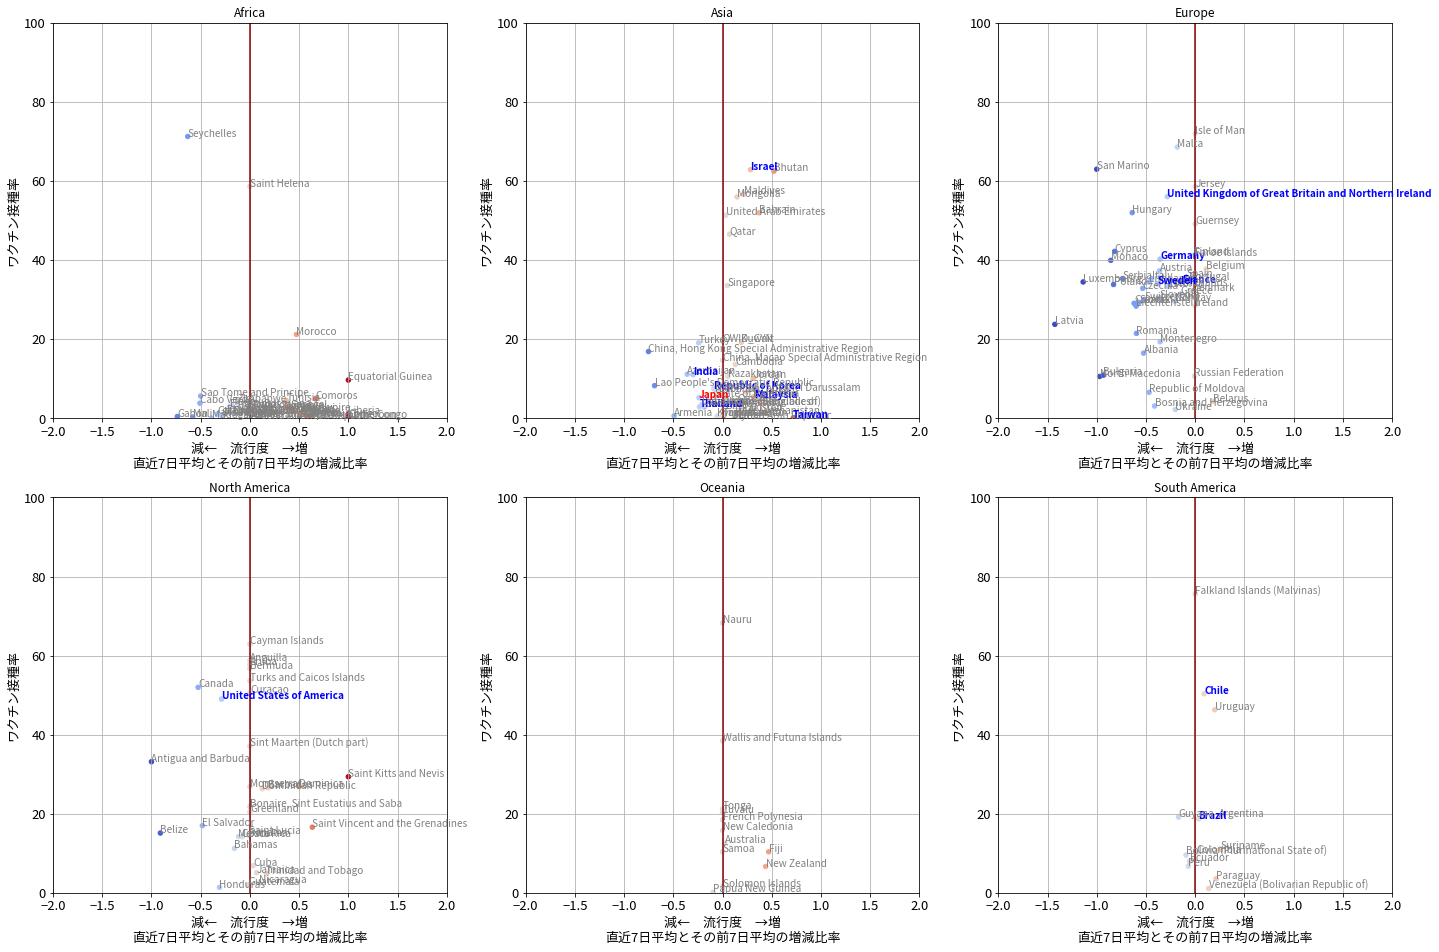

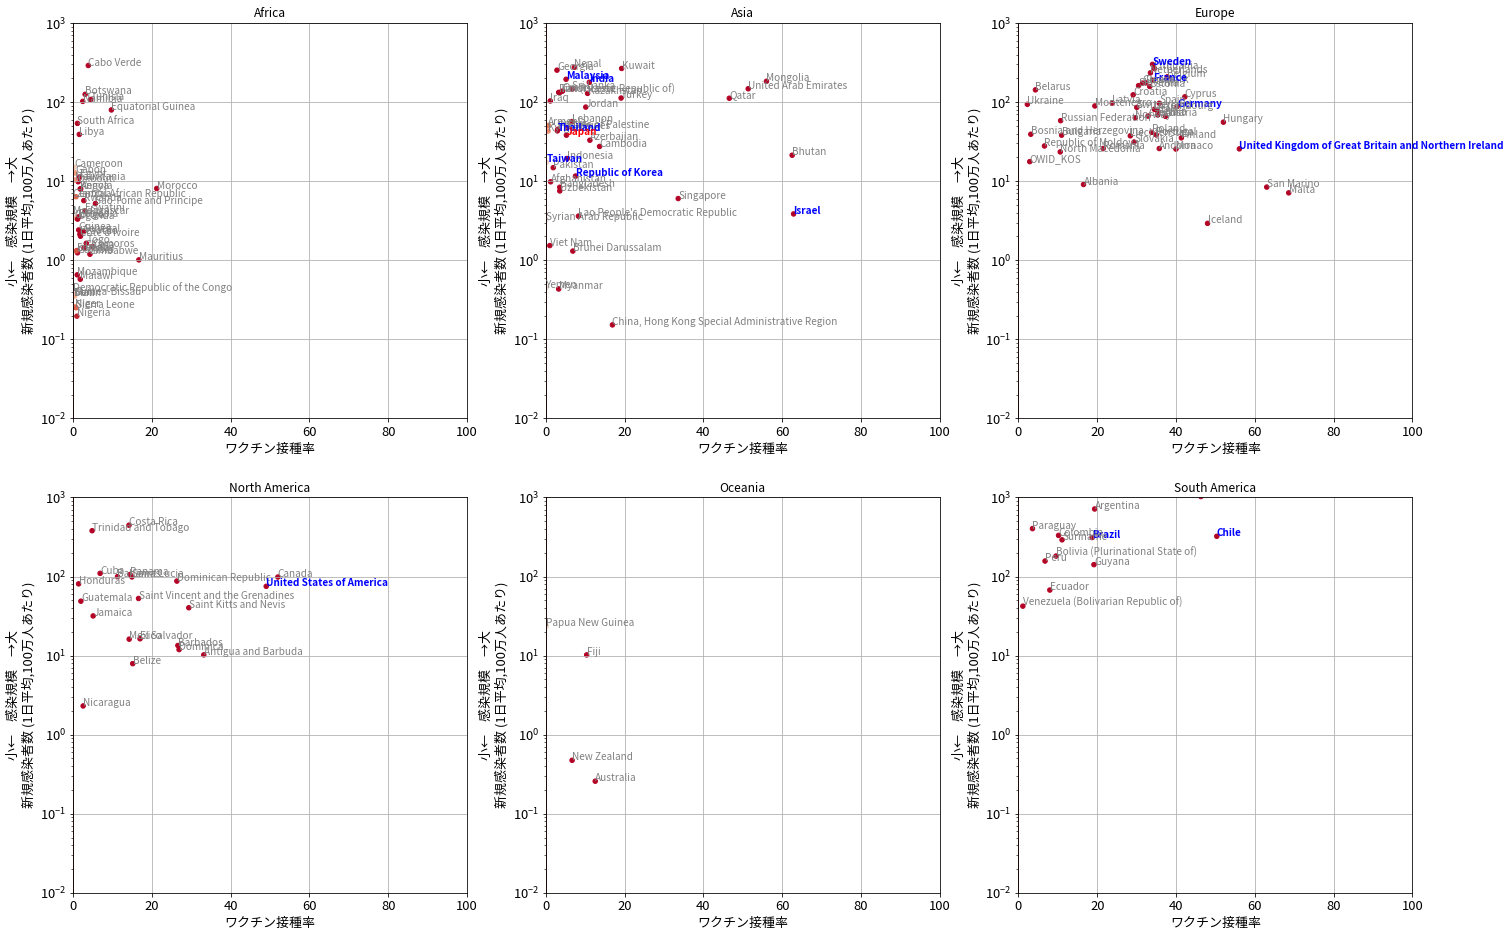

In [23]:
vac = raw_data[['iso_code', 'continent', 'date', 'new_cases_per_million', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred']].sort_values("date")
vac['date'] = pd.to_datetime(vac['date'])
vac.set_index('date', inplace=True)
def extract_vaccinated(subdf):
    c = subdf.name
    meandf = calc_period(subdf)
    trenddf = calc_trends(subdf)
    latestdf = subdf.loc[subdf['people_vaccinated_per_hundred'].notna()]
    if meandf.shape[0] > 0 and latestdf.shape[0] > 0:
        mean = meandf.iloc[-1]
        trend = trenddf.iloc[-1]
        latest = latestdf.iloc[-1]
        return pd.Series([get_country(c),    #country
                          latest.values[1],  #continent 
                          mean.values[0],    #new_cases_per_million
                          trend.values[0],   #trend_cases
                          latest.values[3],  #people_vaccinated_per_hundred
                          latest.values[4]]  #people_vaccinated_per_hundred
                        )

vac_country = vac.groupby("iso_code").apply(extract_vaccinated)
vac_country=vac_country.rename(columns=
    dict(enumerate(['country', 'continent', 'new_cases_per_million', 'trend_cases', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred']))
    )

plot_scatter_per_continent(
    vac_country, 
    y_column="people_vaccinated_per_hundred", 
    x_column="trend_cases",
    y_logscale=False,
    ylim = (0, 100),
    xlim = (-2, 2),
    y_label="ワクチン接種率", 
    x_label="減←　流行度　→増\n直近{freq}日平均とその前{freq}日平均の増減比率".format(freq=freq), 
    filename="world_trends/trend-vaccinated.png")

plot_scatter_per_continent(
    vac_country, 
    x_column="people_vaccinated_per_hundred", 
    y_column=new_cases_label,
    y_logscale=True,
    xlim = (0, 100),
    ylim = (ymin, ymax),
    x_label="ワクチン接種率", 
    y_label="小←　感染規模　→大\n新規感染者数 (1日平均,100万人あたり)", 
    filename="world_trends/per_mill-vaccinated.png")


Extracting training data
[  1.0828511 -19.4833085]
倍化時間：8.708156日


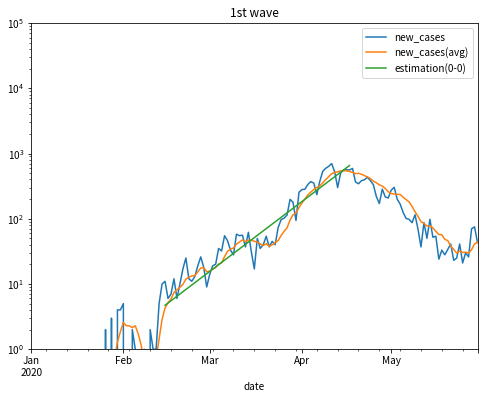

Extracting training data
[  1.0675568  -76.41785679]
倍化時間：10.603011日


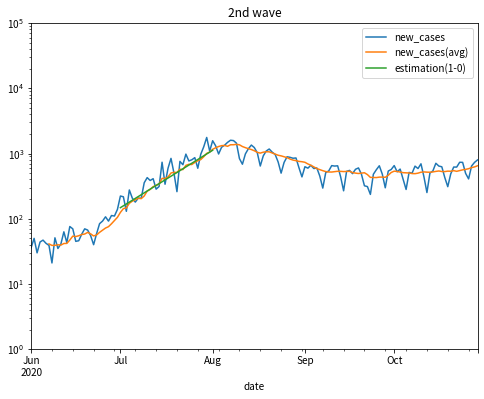

Extracting training data
[   1.05159453 -129.75200004]
倍化時間：13.778176日
Extracting training data
[   1.01552113 -490.46859423]
倍化時間：45.003986日
Extracting training data
[   1.0307377  -275.62413374]
倍化時間：22.895214日


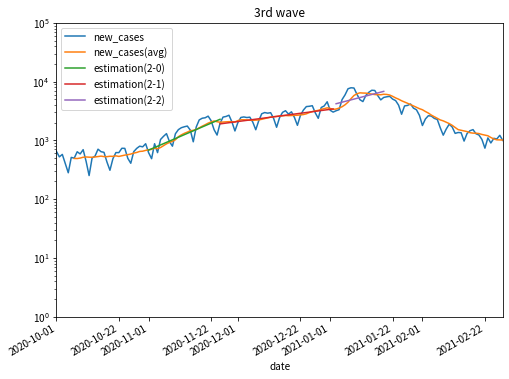

Extracting training data
[   1.04069787 -173.25949589]
倍化時間：17.375804日
Extracting training data
[ 1.00644733e+00 -1.31578881e+03]
倍化時間：107.855423日


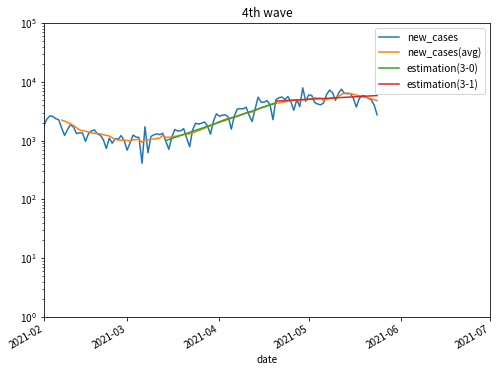

In [24]:
from scipy.optimize import curve_fit
import math

def power_func(x, a, c):
    return (a ** (x-c))

# フィッティング
def fit(df, col, FITTING_START, FITTING_END):
    print("Extracting training data")
    training = df.loc[(df.index >= FITTING_START) & (df.index <= FITTING_END)].copy()
    training["x"] = (training.index - FITTING_START).map(lambda x: x.days)
#    display(training)
    params, cov = curve_fit(power_func, training["x"], training[col], maxfev=100000)
    return params

target_data = data["JPN"]
def num_ord(d):
    suffix = ["th", "st", "nd", "rd"]
    target = d % 10
    if target > 0 and target < 4:
        return "%d%s"%(target, suffix[target])
    else:
        return "%d%s"%(target, suffix[0])

!mkdir -p world_trends/

DT = datetime.datetime
TD = datetime.timedelta

for i, period in enumerate([
    [DT(2020,  1, 1), None, [DT(2020, 2, 15), DT(2020, 4, 17)]], 
    [DT(2020,  6, 1), None, [DT(2020, 7, 1), DT(2020, 8, 1)]], 
    [DT(2020, 10, 1), None, [DT(2020, 11, 1), DT(2020, 11, 25)], [DT(2020, 11, 25), DT(2021, 1, 2)], [DT(2021, 1, 3), DT(2021, 1, 19)]],
    [DT(2021,  2, 1), None, [DT(2021, 3, 14), DT(2021, 4, 20)], [DT(2021, 4, 20), DT.now()]], 
]):
    period[1] = period[0] + TD(days=150)
    target_period = target_data.loc[(target_data.index>=period[0]) & (target_data.index<=period[1])].copy()
    target_period["new_cases(avg)"] = target_period["new_cases"].rolling(7).mean()

    fitting_periods = period[2:]
    estimated_ys = []
    eval = None
    for j, fp in enumerate(fitting_periods):
        params = fit(target_period, "new_cases(avg)", fp[0], fp[1])
        print(params)
        print("倍化時間：%f日"%(math.log(2) / math.log(params[0])))
        e = target_period.loc[(target_period.index>=fp[0])&(target_period.index<=fp[1])].copy()
        e["x"] = (e.index - fp[0]).map(lambda x: x.days)
        new_y = "estimation(%d-%d)"%(i,j)
        e[new_y] = e["x"].map(lambda x: power_func(x, *params))
        estimated_ys.append(new_y)
        if not eval is None:
            eval = pd.concat([eval, e])
        else:
            eval = e
    eval = eval[["x"] + estimated_ys]
    target_period = target_period.join(eval, how="outer")

    ord_text = num_ord(i+1)
    ax = target_period.plot(kind="line", logy=True, y = ["new_cases", "new_cases(avg)"] + estimated_ys, ylim =(10**0,10**5), xlim=(period[0], period[1]), figsize=(8, 6), title = "%s wave"%ord_text)
    plt.show()
    ax.figure.savefig("world_trends/jpn-positive-logscale-%s.png"%ord_text)
    plt.close()

In [25]:
d1=data["DEU"]["new_cases_per_million"]
d2=data["GBR"]["new_cases_per_million"]
d3=data["ISR"]["new_cases_per_million"]
d4=data["JPN"]["new_cases_per_million"]
display(d1)
display(d2)
display(d3)
display(d4)
display(d4[-1]/d1[-1])
display(d4[-1]/d2[-1])
display(d4[-1]/d3[-1])


date
2020-01-27      0.012
2020-01-28      0.036
2020-01-29      0.000
2020-01-30      0.000
2020-01-31      0.012
               ...   
2021-05-20    128.032
2021-05-21     96.629
2021-05-22     76.614
2021-05-23     55.416
2021-05-24     27.786
Name: new_cases_per_million, Length: 484, dtype: float64

date
2020-01-31     0.029
2020-02-01     0.000
2020-02-02     0.000
2020-02-03     0.088
2020-02-04     0.000
               ...  
2021-05-20    39.758
2021-05-21    39.890
2021-05-22    37.180
2021-05-23    30.831
2021-05-24    34.911
Name: new_cases_per_million, Length: 480, dtype: float64

date
2020-02-20      NaN
2020-02-21    0.116
2020-02-22    0.000
2020-02-23    0.000
2020-02-24    0.000
              ...  
2021-05-21    3.119
2021-05-22    2.080
2021-05-23    1.271
2021-05-24    5.546
2021-05-25      NaN
Name: new_cases_per_million, Length: 461, dtype: float64

date
2020-01-22       NaN
2020-01-23     0.000
2020-01-24     0.000
2020-01-25     0.000
2020-01-26     0.016
               ...  
2021-05-20    45.147
2021-05-21    41.541
2021-05-22    39.414
2021-05-23    31.982
2021-05-24    21.688
Name: new_cases_per_million, Length: 489, dtype: float64

0.7805369610595263

0.6212368594425826

nan